# Final CNN

In [276]:
%reset -f

In [277]:
# import math
import pandas as pd
import numpy as np
# import re
# import csv
# from datetime import datetime
# import folium
# from folium import plugins
import matplotlib.pyplot as plt
# import os

from keras.models import Sequential
from keras.layers import Dense, Flatten  
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import r2_score

file_path = "C:\\Users\\jerem\\Documents\\TrundleWheel\\Data\\User1_Jeremy_Bezancon\\all_datas_2" # without GPS datas
all_data = pd.read_csv(file_path+'.csv', sep=';')

In [278]:
# Find indexes of valid, train and test data in the "all_datas_2" file

walk_start = [0] # indexes where each walk begin 
test_start = [] # indexes where each test data begin (4 last minutes of each walk (= 1 hour))
chunk_test = 14400 # = 60*60*4 = 4 minutes

for i in range(len(all_data) - 1):
    current_value = all_data.iloc[i, 0]
    next_value = all_data.iloc[i + 1, 0]

    if current_value > next_value:
        walk_start.append(i-1)
        test_start.append(i-(chunk_test)-1);
        
# add the last walk index
walk_start.append(len(all_data)-1)
test_start.append(len(all_data) - (chunk_test)-1)
        
print("walk_start = ",walk_start)
print("test_start = ",test_start)


# Split the data:
#  - Test data = 1 hour (4 mins of each walk)
#  - Train data = 70% of remaining data 
#  - Valid data = 30% of remaining data 

# Columns 0 to 11 : [time, m_acc_x, m_acc_y, m_acc_z, m_accG_x, m_accG_y, m_accG_z, m_rotTate_alpha, m_rotTate_beta, m_rotTate_gamma, steps, distance]
col_s = 4 # first column
col_f = 10 # last column

X_train_list = []
Y_train_list = []
X_valid_list = []
Y_valid_list = []
X_test_list = []
Y_test_list = []

# number of rows of train and valid data given to the algorithm at eact itteration in the loop
chunk = 300 # 300 = 60*5 = 5 secs

for walk_idx in range(len(walk_start)-1):
    
    # for train and valid data
    start_idx = walk_start[walk_idx]
    end_idx = test_start[walk_idx]
    split_point = start_idx + int((end_idx-start_idx) * 0.7) # index where train data stop and valid data start
    # Ajust split_point and end_idx because valid and train data must be divisible by chunks
    split_point = split_point - (split_point-start_idx)%chunk 
    end_idx = end_idx - (end_idx-split_point)%chunk
    
    X_train_list.append(all_data.iloc[start_idx:split_point, col_s:col_f])
    Y_train_list.append(all_data.iloc[start_idx:split_point]['distance'])   
    X_valid_list.append(all_data.iloc[split_point:end_idx, col_s:col_f])
    Y_valid_list.append(all_data.iloc[split_point:end_idx]['distance'])
    
    
    # for test data
    start_idx = test_start[walk_idx]
    end_idx = walk_start[walk_idx+1]
    X_test_list.append(all_data.iloc[start_idx:end_idx, col_s:col_f])
    Y_test_list.append(all_data.iloc[start_idx:end_idx]['distance'])
    
X_train = pd.concat(X_train_list, ignore_index=True)
y_train = pd.concat(Y_train_list, ignore_index=True)
X_valid = pd.concat(X_valid_list, ignore_index=True)
y_valid = pd.concat(Y_valid_list, ignore_index=True)
X_test = pd.concat(X_test_list, ignore_index=True)
y_test = pd.concat(Y_test_list, ignore_index=True)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

walk_start =  [0, 45707, 94349, 141283, 204708, 267536, 314470, 354269, 389073, 425639, 470657, 519844, 572119, 624270, 669829, 716147]
test_start =  [31307, 79949, 126883, 190308, 253136, 300070, 339869, 374673, 411239, 456257, 505444, 557719, 609870, 655429, 701747]
X_train shape: (347988, 6)
y_train shape: (347988,)
X_valid shape: (150000, 6)
y_valid shape: (150000,)
X_test shape: (216000, 6)
y_test shape: (216000,)


In [319]:
#normalize data between 0 and 1
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)

In [335]:
# Define CNN parameters:

model = Sequential()

model.add(Dense(32,input_shape = (chunk, col_f-col_s),kernel_initializer = 'uniform',activation='relu'))
model.add(Dense(32,kernel_initializer = 'uniform',activation='relu'))
# model.add(Dense(1,kernel_initializer = 'uniform'))
model.add(Flatten())
model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

model.summary()

model.compile(optimizer = Adam(0.01),loss = 'mse',metrics=['mse'])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 300, 32)           224       
                                                                 
 dense_36 (Dense)            (None, 300, 32)           1056      
                                                                 
 flatten_9 (Flatten)         (None, 9600)              0         
                                                                 
 dense_37 (Dense)            (None, 1)                 9601      
                                                                 
Total params: 10881 (42.50 KB)
Trainable params: 10881 (42.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [336]:
# Run the CNN

#fix random seed for reproductability
seed = 7
np.random.seed(seed)

hist = []

for i in range(0, len(X_train) - chunk, chunk):  
# for i in range(0, 20000, chunk):  
    
    print(i,' / ',len(X_train) - chunk)
    
    # new train and valid data for each itteration in the loop  
    X_t = X_train_normalized[i:i+chunk, :] 
    y_t = y_train[i+chunk-1] - y_train[i] # distance walked during 5 secs
    print("i = ",i,"y_t = ",y_t)
    if(y_t>0): # if not: distance difference between two differents walks
        X_t = np.array(X_t)
        y_t = np.array(y_t)
        y_t = y_t.reshape(-1, 1)

        # select random valids values among valid data
        index_v = int(np.random.rand()*(len(X_valid_normalized)-301))
        X_v = X_valid_normalized[index_v:index_v+chunk, :] 
        y_v = y_valid[index_v+chunk] - y_valid[index_v]
        X_v = np.array(X_v)
        y_v = np.array(y_v)
        y_v = y_v.reshape(-1, 1)

        X_t = np.expand_dims(X_t, axis=0)
        y_t = np.expand_dims(y_t, axis=0)

        X_v = np.expand_dims(X_v, axis=0)
        y_v = np.expand_dims(y_v, axis=0)

        model.fit(X_t,y_t,epochs = 10,batch_size = 10,validation_data =(X_v,y_v))
    
    

0  /  347400
i =  0 y_t =  4.587245934959329
Epoch 1/10
1/1 [==============================] - 1s 970ms/step - loss: 20.9895 - mse: 20.9895 - val_loss: 34.4464 - val_mse: 34.4464
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 15.8188 - mse: 15.8188 - val_loss: 17.2859 - val_mse: 17.2859
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 5.0764 - mse: 5.0764 - val_loss: 0.2088 - val_mse: 0.2088
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 2.1840 - mse: 2.1840 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 4.0684 - mse: 4.0684 - val_loss: 2.5548 - val_mse: 2.5548
Epoch 6/10
1/1 [==============================] - 0s 44ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 8.7202 - val_mse: 8.7202
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 1.0899 - mse: 1.0899 - val_loss: 11.4412 - val_mse: 11.4412
Epoch 8/10
1/1 [=========================

1/1 [==============================] - 0s 74ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 5.8469 - val_mse: 5.8469
Epoch 2/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 5.6706 - val_mse: 5.6706
Epoch 3/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 5.1478 - val_mse: 5.1478
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 4.6041 - val_mse: 4.6041
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 4.3339 - val_mse: 4.3339
Epoch 6/10
1/1 [==============================] - 0s 47ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 4.4518 - val_mse: 4.4518
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 4.8617 - val_mse: 4.8617
Epoch 8/10
1/1 [==============================] - 0s 46ms/step - loss: 7.4620e-04 - mse: 7.4620e-04 - val_lo

1/1 [==============================] - 0s 85ms/step - loss: 0.1452 - mse: 0.1452 - val_loss: 2.4778 - val_mse: 2.4778
Epoch 2/10
1/1 [==============================] - 0s 45ms/step - loss: 9.0147e-04 - mse: 9.0147e-04 - val_loss: 1.5644 - val_mse: 1.5644
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0899 - mse: 0.0899 - val_loss: 1.4104 - val_mse: 1.4104
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1329 - mse: 0.1329 - val_loss: 1.9621 - val_mse: 1.9621
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 2.9388 - val_mse: 2.9388
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 3.4653 - val_mse: 3.4653
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1031 - mse: 0.1031 - val_loss: 2.9689 - val_mse: 2.9689
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0322 - mse: 0.0322 - val_lo

1/1 [==============================] - 0s 83ms/step - loss: 3.8865e-05 - mse: 3.8865e-05 - val_loss: 0.6789 - val_mse: 0.6789
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.6999 - val_mse: 0.6999
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.9356 - val_mse: 0.9356
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 3.1050e-04 - mse: 3.1050e-04 - val_loss: 1.1367 - val_mse: 1.1367
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 1.0754 - val_mse: 1.0754
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.8472 - val_mse: 0.8472
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 8.4044e-04 - mse: 8.4044e-04 - val_loss: 0.7123 - val_mse: 0.7123
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0114 - mse:

1/1 [==============================] - 0s 97ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.1278 - val_mse: 0.1278
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0467 - mse: 0.0467 - val_loss: 0.1447 - val_mse: 0.1447
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.3538 - val_mse: 0.3538
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.3993 - val_mse: 0.3993
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.2148 - val_mse: 0.2148
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 1.0926e-05 - mse: 1.0926e-05 - val_loss: 0.0962 - val_mse: 0.0962
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0228 - mse: 0.0228 - val_lo

1/1 [==============================] - 0s 88ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 3.8220 - val_mse: 3.8220
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 3.2979 - val_mse: 3.2979
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 6.4434e-04 - mse: 6.4434e-04 - val_loss: 2.7709 - val_mse: 2.7709
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 2.7763 - val_mse: 2.7763
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 3.2543 - val_mse: 3.2543
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 1.6791e-04 - mse: 1.6791e-04 - val_loss: 3.6675 - val_mse: 3.6675
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 3.5137 - val_mse: 3.5137
Epoch 8/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0070 - mse: 0.0070 

1/1 [==============================] - 0s 87ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 44.6643 - val_mse: 44.6643
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 43.8615 - val_mse: 43.8615
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 2.0460e-05 - mse: 2.0460e-05 - val_loss: 43.0894 - val_mse: 43.0894
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 43.0972 - val_mse: 43.0972
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 43.8003 - val_mse: 43.8003
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 2.2737e-09 - mse: 2.2737e-09 - val_loss: 44.4420 - val_mse: 44.4420
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 44.3758 - val_mse: 44.3758
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0019 

Epoch 1/10
1/1 [==============================] - 0s 87ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 35265.9922 - val_mse: 35265.9922
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 35339.3828 - val_mse: 35339.3828
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 35344.4805 - val_mse: 35344.4805
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 35282.0195 - val_mse: 35282.0195
Epoch 5/10
1/1 [==============================] - 0s 44ms/step - loss: 6.2120e-05 - mse: 6.2120e-05 - val_loss: 35229.7305 - val_mse: 35229.7305
Epoch 6/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 35242.5352 - val_mse: 35242.5352
Epoch 7/10
1/1 [==============================] - 0s 47ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 35300.5977 - val_mse: 35300.5977
Epoch 8/10
1/1 [=================

1/1 [==============================] - 0s 37ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0701 - val_mse: 0.0701
14400  /  347400
i =  14400 y_t =  6.774451754385495
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 1.2656e-04 - mse: 1.2656e-04 - val_loss: 0.2824 - val_mse: 0.2824
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.2591 - val_mse: 0.2591
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.1944 - val_mse: 0.1944
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 5.5929e-04 - mse: 5.5929e-04 - val_loss: 0.1641 - val_mse: 0.1641
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.1904 - val_mse: 0.1904
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 7.9662e-04 - mse: 7.9662e-04 - val_loss: 0.2450 - val_mse: 0.2450
Epoch 7/10
1/1 [===============

1/1 [==============================] - 0s 36ms/step - loss: 1.1008e-04 - mse: 1.1008e-04 - val_loss: 5.1576 - val_mse: 5.1576
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 5.3769e-04 - mse: 5.3769e-04 - val_loss: 5.2227 - val_mse: 5.2227
16200  /  347400
i =  16200 y_t =  6.4639417693182395
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 8.6587e-04 - mse: 8.6587e-04 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 3/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 1.9751e-04 - val_mse: 1.9751e-04
Epoch 4/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 5/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0653 - val_mse: 0.0653
Epoch 6/10
1/1 [=====

1/1 [==============================] - 0s 41ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 1.1682 - val_mse: 1.1682
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 1.3644 - val_mse: 1.3644
18000  /  347400
i =  18000 y_t =  6.608492822965388
Epoch 1/10
1/1 [==============================] - 0s 76ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 4.6198 - val_mse: 4.6198
Epoch 2/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 4.0000 - val_mse: 4.0000
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 3.8895 - val_mse: 3.8895
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 4.3582 - val_mse: 4.3582
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 1.2438e-05 - mse: 1.2438e-05 - val_loss: 4.8170 - val_mse: 4.8170
Epoch 6/10
1/1 [==============================

1/1 [==============================] - 0s 34ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 7.1014 - val_mse: 7.1014
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 7.0397 - val_mse: 7.0397
19800  /  347400
i =  19800 y_t =  6.935917312660877
Epoch 1/10
1/1 [==============================] - 0s 93ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 1.6827 - val_mse: 1.6827
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 1.2755 - val_mse: 1.2755
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 1.5491 - val_mse: 1.5491
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 2.1354 - val_mse: 2.1354
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 2.2394 - val_mse: 2.2394
Epoch 6/10
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 36ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 50254.1094 - val_mse: 50254.1094
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 50300.6836 - val_mse: 50300.6836
21600  /  347400
i =  21600 y_t =  6.622979797979497
Epoch 1/10
1/1 [==============================] - 0s 92ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 3.3079 - val_mse: 3.3079
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 3.0321 - val_mse: 3.0321
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 5.1085e-06 - mse: 5.1085e-06 - val_loss: 2.7858 - val_mse: 2.7858
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 2.8600 - val_mse: 2.8600
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 3.1366 - val_mse: 3.1366
Epoch 6/10
1/1 [==============

1/1 [==============================] - 0s 38ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 1.9003 - val_mse: 1.9003
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 1.9790e-04 - mse: 1.9790e-04 - val_loss: 1.7767 - val_mse: 1.7767
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 9.9272e-04 - mse: 9.9272e-04 - val_loss: 1.7716 - val_mse: 1.7716
23700  /  347400
i =  23700 y_t =  6.201579670329991
Epoch 1/10
1/1 [==============================] - 0s 84ms/step - loss: 0.0844 - mse: 0.0844 - val_loss: 2.2968 - val_mse: 2.2968
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 1.6346 - val_mse: 1.6346
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0916 - mse: 0.0916 - val_loss: 1.9810 - val_mse: 1.9810
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 2.9843 - val_mse: 2.9843
Epoch 5/10
1/1 [======================

1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2420 - val_mse: 0.2420
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.1931 - val_mse: 0.1931
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 3.0128e-04 - mse: 3.0128e-04 - val_loss: 0.1375 - val_mse: 0.1375
25500  /  347400
i =  25500 y_t =  6.193014705882433
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 2/10
1/1 [==============================] - 0s 43ms/step - loss: 6.1674e-04 - mse: 6.1674e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 4.5959e-04 - val_mse: 4.5959e-04
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 5/10
1/1 [==============

1/1 [==============================] - 0s 37ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.2577 - val_mse: 0.2577
Epoch 9/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.1438 - val_mse: 0.1438
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1079 - val_mse: 0.1079
27300  /  347400
i =  27300 y_t =  6.16286514605865
Epoch 1/10
1/1 [==============================] - 0s 76ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 55352.9141 - val_mse: 55352.9141
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 2.6209e-04 - mse: 2.6209e-04 - val_loss: 55285.2812 - val_mse: 55285.2812
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 55293.1367 - val_mse: 55293.1367
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 55360.2617 - val_mse: 55360.2617
Epoch 5/10
1/1 

Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 3.5752 - val_mse: 3.5752
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 3.9268 - val_mse: 3.9268
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 3.5741 - val_mse: 3.5741
Epoch 10/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 3.0181 - val_mse: 3.0181
29100  /  347400
i =  29100 y_t =  6.121293800538922
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 3.2512e-04 - mse: 3.2512e-04 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 2/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/10
1/1 [===================

1/1 [==============================] - 0s 39ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 2.2575 - val_mse: 2.2575
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 9.1819e-04 - mse: 9.1819e-04 - val_loss: 2.1233 - val_mse: 2.1233
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 2.2755 - val_mse: 2.2755
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 5.9179e-04 - mse: 5.9179e-04 - val_loss: 2.5119 - val_mse: 2.5119
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 2.5253 - val_mse: 2.5253
30900  /  347400
i =  30900 y_t =  6.099090909090819
Epoch 1/10
1/1 [==============================] - 0s 94ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 1.0599e-04 - mse: 1.0599e-04 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 3/10
1/1 [==============

Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 39.1163 - val_mse: 39.1163
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 40.3865 - val_mse: 40.3865
Epoch 8/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 39.2962 - val_mse: 39.2962
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 37.5789 - val_mse: 37.5789
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 37.5006 - val_mse: 37.5006
32700  /  347400
i =  32700 y_t =  6.076495289978567
Epoch 1/10
1/1 [==============================] - 0s 87ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.1696 - val_mse: 0.1696
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 3.6307e-04 - mse: 3.6307e-04 - val_loss: 0.2000 - val_mse: 0.2000
Epoch 3/10
1/1 [=========

Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 8.2917e-04 - mse: 8.2917e-04 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 8/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0045 - val_mse: 0.0045
34500  /  347400
i =  34500 y_t =  6.046990291261352
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 1.6563 - val_mse: 1.6563
Epoch 2/10
1/1 [===================

1/1 [==============================] - 0s 36ms/step - loss: 1.2586e-05 - mse: 1.2586e-05 - val_loss: 0.2297 - val_mse: 0.2297
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.2083 - val_mse: 0.2083
Epoch 6/10
1/1 [==============================] - 0s 35ms/step - loss: 6.3978e-04 - mse: 6.3978e-04 - val_loss: 0.1620 - val_mse: 0.1620
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 8.2308e-04 - mse: 8.2308e-04 - val_loss: 0.1535 - val_mse: 0.1535
Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.1887 - val_mse: 0.1887
Epoch 9/10
1/1 [==============================] - 0s 34ms/step - loss: 1.0894e-05 - mse: 1.0894e-05 - val_loss: 0.2193 - val_mse: 0.2193
Epoch 10/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.2024 - val_mse: 0.2024
36300  /  347400
i =  36300 y_t =  6.271683673468942
Epoch 1/10
1/1 [======

1/1 [==============================] - 0s 37ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 1.5158e-06 - val_mse: 1.5158e-06
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 8.9530e-04 - mse: 8.9530e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 6.0141e-04 - val_mse: 6.0141e-04
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 1.7369e-05 - mse: 1.7369e-05 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 4.7601e-05 - val_mse: 4.7601e-05
38100  /  347400
i =  38100 y_t =  6.347368421051613
Epoch 1/10
1/1

Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 8.0810e-04 - mse: 8.0810e-04 - val_loss: 1.5336 - val_mse: 1.5336
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 8.6459e-05 - mse: 8.6459e-05 - val_loss: 1.4590 - val_mse: 1.4590
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 4.4991e-04 - mse: 4.4991e-04 - val_loss: 1.4659 - val_mse: 1.4659
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 3.3736e-04 - mse: 3.3736e-04 - val_loss: 1.5366 - val_mse: 1.5366
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 1.0989e-04 - mse: 1.0989e-04 - val_loss: 1.5638 - val_mse: 1.5638
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 4.5941e-04 - mse: 4.5941e-04 - val_loss: 1.5118 - val_mse: 1.5118
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 1.9455e-07 - mse: 1.9455e-07 - val_loss: 1.4642 - val_mse: 1.4642
39900  /  347400
i =  39900 y_t =  6.012

Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0495 - mse: 0.0495 - val_loss: 0.1511 - val_mse: 0.1511
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0873 - val_mse: 0.0873
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.1942 - val_mse: 0.1942
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 9/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0158 - mse: 0.0158 - va

1/1 [==============================] - 0s 36ms/step - loss: 0.0631 - mse: 0.0631 - val_loss: 0.7141 - val_mse: 0.7141
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 6.4973e-04 - mse: 6.4973e-04 - val_loss: 1.1845 - val_mse: 1.1845
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.9839 - val_mse: 0.9839
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.5386 - val_mse: 0.5386
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.4791 - val_mse: 0.4791
Epoch 8/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.8100 - val_mse: 0.8100
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 8.6991e-04 - mse: 8.6991e-04 - val_loss: 1.0982 - val_mse: 1.0982
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0315 - mse: 0.0315

Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 6.8588e-04 - mse: 6.8588e-04 - val_loss: 0.0561 - val_mse: 0.0561
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 7.1475e-04 - mse: 7.1475e-04 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 1.2256e-04 - mse: 1.2256e-04 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
1/1 [==============================] - 0s 35ms/step - loss: 8.5521e-04 - mse: 8.5521e-04 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 1.1378e-05 - mse: 1.1378e-05 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 6.1161e-04 - mse: 6.1161e-04 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 9/10
1/1 [==============================] - 0s 44ms/step - loss: 2.1096e-04 - mse: 2.1096e-04 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 10/10
1/1 [========================

1/1 [==============================] - 0s 40ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 3.4930 - val_mse: 3.4930
Epoch 3/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 3.9609 - val_mse: 3.9609
Epoch 4/10
1/1 [==============================] - 0s 44ms/step - loss: 2.5083e-04 - mse: 2.5083e-04 - val_loss: 4.3079 - val_mse: 4.3079
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 3.9730 - val_mse: 3.9730
Epoch 6/10
1/1 [==============================] - 0s 43ms/step - loss: 3.5611e-04 - mse: 3.5611e-04 - val_loss: 3.5735 - val_mse: 3.5735
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 3.7136 - val_mse: 3.7136
Epoch 8/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 4.1358 - val_mse: 4.1358
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0035 - mse: 0.0035 

1/1 [==============================] - 0s 40ms/step - loss: 5.3055e-04 - mse: 5.3055e-04 - val_loss: 0.7709 - val_mse: 0.7709
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.6613 - val_mse: 0.6613
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 2.6906e-08 - mse: 2.6906e-08 - val_loss: 0.5689 - val_mse: 0.5689
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.6328 - val_mse: 0.6328
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 3.0735e-04 - mse: 3.0735e-04 - val_loss: 0.7403 - val_mse: 0.7403
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.7118 - val_mse: 0.7118
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 9.4022e-04 - mse: 9.4022e-04 - val_loss: 0.6080 - val_mse: 0.6080
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.001

Epoch 2/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 3.9291 - val_mse: 3.9291
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 3.7683 - val_mse: 3.7683
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 3.2022 - val_mse: 3.2022
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 3.1891 - val_mse: 3.1891
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 3.6913 - val_mse: 3.6913
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 3.8467 - val_mse: 3.8467
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 3.4158 - val_mse: 3.4158
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 5.2969e-04 - mse: 5.2969e-

1/1 [==============================] - 0s 47ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.1218 - mse: 0.1218 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2129 - val_mse: 0.2129
Epoch 5/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0964 - mse: 0.0964 - val_loss: 0.0723 - val_mse: 0.0723
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0849 - val_mse: 0.0849
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.14

1/1 [==============================] - 0s 36ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 5.1778 - val_mse: 5.1778
Epoch 3/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 4.5625 - val_mse: 4.5625
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 4.7053 - val_mse: 4.7053
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 5.3249 - val_mse: 5.3249
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 5.4612 - val_mse: 5.4612
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 4.9557 - val_mse: 4.9557
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 2.7206e-04 - mse: 2.7206e-04 - val_loss: 4.6229 - val_mse: 4.6229
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0086 - mse: 0.0086 - val_lo

1/1 [==============================] - 0s 86ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 1.6638 - val_mse: 1.6638
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 1.6419 - val_mse: 1.6419
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 1.9720 - val_mse: 1.9720
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 9.0056e-04 - mse: 9.0056e-04 - val_loss: 2.1694 - val_mse: 2.1694
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 1.9391 - val_mse: 1.9391
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 3.3214e-04 - mse: 3.3214e-04 - val_loss: 1.6764 - val_mse: 1.6764
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 1.7393 - val_mse: 1.7393
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - mse: 0.0031 

Epoch 1/10
1/1 [==============================] - 0s 87ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 3.8436 - val_mse: 3.8436
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 2.9405 - val_mse: 2.9405
Epoch 3/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 2.6170 - val_mse: 2.6170
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 3.2257 - val_mse: 3.2257
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 5.4980e-07 - mse: 5.4980e-07 - val_loss: 3.8321 - val_mse: 3.8321
Epoch 6/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 3.4208 - val_mse: 3.4208
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 2.7896 - val_mse: 2.7896
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0156 - mse: 0.01

1/1 [==============================] - 0s 87ms/step - loss: 0.0719 - mse: 0.0719 - val_loss: 1.7144 - val_mse: 1.7144
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 1.2742 - val_mse: 1.2742
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0852 - mse: 0.0852 - val_loss: 1.8533 - val_mse: 1.8533
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 2.7536 - val_mse: 2.7536
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 2.5012 - val_mse: 2.5012
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 1.6465 - val_mse: 1.6465
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 1.4578 - val_mse: 1.4578
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 2.04

1/1 [==============================] - 0s 35ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 2.2833 - val_mse: 2.2833
61500  /  347400
i =  61500 y_t =  6.178101772439277
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.0701 - mse: 0.0701 - val_loss: 4.0309 - val_mse: 4.0309
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 4.9417 - val_mse: 4.9417
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0635 - mse: 0.0635 - val_loss: 4.3215 - val_mse: 4.3215
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 3.2323 - val_mse: 3.2323
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 3.2027 - val_mse: 3.2027
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 4.1580 - val_mse: 4.1580
Epoch 7/10
1/1 [==============================] - 0s 36

1/1 [==============================] - 0s 40ms/step - loss: 4.8932e-06 - mse: 4.8932e-06 - val_loss: 36067.9609 - val_mse: 36067.9609
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 5.2104e-04 - mse: 5.2104e-04 - val_loss: 36073.5820 - val_mse: 36073.5820
63300  /  347400
i =  63300 y_t =  6.416521063869425
Epoch 1/10
1/1 [==============================] - 0s 92ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 2/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0474 - val_mse: 0.0474
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 6.9848e-05 - mse: 6.9848e-05 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 6/10
1/1

1/1 [==============================] - 0s 38ms/step - loss: 4.5839e-08 - mse: 4.5839e-08 - val_loss: 0.1829 - val_mse: 0.1829
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.1540 - val_mse: 0.1540
65100  /  347400
i =  65100 y_t =  6.518029115340255
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 3.4262e-04 - mse: 3.4262e-04 - val_loss: 1.2300 - val_mse: 1.2300
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 1.2088 - val_mse: 1.2088
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 1.0855 - val_mse: 1.0855
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 6.5463e-04 - mse: 6.5463e-04 - val_loss: 1.0589 - val_mse: 1.0589
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 1.1575 - val_mse: 1.1575
Epoch 6/10
1/1 [==============

Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 2.1433 - val_mse: 2.1433
Epoch 10/10
1/1 [==============================] - 0s 43ms/step - loss: 3.8426e-09 - mse: 3.8426e-09 - val_loss: 2.0313 - val_mse: 2.0313
66900  /  347400
i =  66900 y_t =  6.419354838709069
Epoch 1/10
1/1 [==============================] - 0s 81ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 1.9343 - val_mse: 1.9343
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 2.4911e-08 - mse: 2.4911e-08 - val_loss: 2.1051 - val_mse: 2.1051
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 1.9940 - val_mse: 1.9940
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 4.4702e-04 - mse: 4.4702e-04 - val_loss: 1.8083 - val_mse: 1.8083
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 1.8357 - val_mse: 1.8357
Epoch 6/10
1/1 [===

1/1 [==============================] - 0s 38ms/step - loss: 0.8686 - mse: 0.8686 - val_loss: 3.3030 - val_mse: 3.3030
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.1497 - mse: 0.1497 - val_loss: 6.0624 - val_mse: 6.0624
Epoch 10/10
1/1 [==============================] - 0s 49ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 8.3516 - val_mse: 8.3516
69000  /  347400
i =  69000 y_t =  4.14871794871781
Epoch 1/10
1/1 [==============================] - 0s 91ms/step - loss: 0.4837 - mse: 0.4837 - val_loss: 8.5407 - val_mse: 8.5407
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.6405 - mse: 0.6405 - val_loss: 7.4094 - val_mse: 7.4094
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.3599 - mse: 0.3599 - val_loss: 5.2770 - val_mse: 5.2770
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 3.2879 - val_mse: 3.2879
Epoch 5/10
1/1 [==============================] - 0s 40

1/1 [==============================] - 0s 36ms/step - loss: 1.2667e-04 - mse: 1.2667e-04 - val_loss: 3.0142 - val_mse: 3.0142
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 2.8242 - val_mse: 2.8242
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 2.9048 - val_mse: 2.9048
70800  /  347400
i =  70800 y_t =  4.417634408602048
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 4.5891 - val_mse: 4.5891
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 2.6003e-05 - mse: 2.6003e-05 - val_loss: 4.7713 - val_mse: 4.7713
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 4.8629 - val_mse: 4.8629
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 4.8293 - val_mse: 4.8293
Epoch 5/10
1/1 [======================

1/1 [==============================] - 0s 45ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 8.6968 - val_mse: 8.6968
Epoch 9/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 8.2310 - val_mse: 8.2310
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 7.5320 - val_mse: 7.5320
72600  /  347400
i =  72600 y_t =  4.557337610264767
Epoch 1/10
1/1 [==============================] - 0s 77ms/step - loss: 7.2260e-05 - mse: 7.2260e-05 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0451 - val_mse: 0.0451
Epoch 5/10
1/1 [==============================

1/1 [==============================] - 0s 36ms/step - loss: 7.8999e-04 - mse: 7.8999e-04 - val_loss: 3.7556 - val_mse: 3.7556
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 5.7752e-04 - mse: 5.7752e-04 - val_loss: 3.8154 - val_mse: 3.8154
Epoch 9/10
1/1 [==============================] - 0s 34ms/step - loss: 7.5092e-05 - mse: 7.5092e-05 - val_loss: 3.8861 - val_mse: 3.8861
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 8.7205e-05 - mse: 8.7205e-05 - val_loss: 3.9322 - val_mse: 3.9322
74400  /  347400
i =  74400 y_t =  4.782485875706072
Epoch 1/10
1/1 [==============================] - 0s 84ms/step - loss: 0.1366 - mse: 0.1366 - val_loss: 3.4243 - val_mse: 3.4243
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 2.5347 - val_mse: 2.5347
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 1.9166 - val_mse: 1.9166
Epoch 4/10
1/1 [======

Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.1542 - mse: 0.1542 - val_loss: 5.4668 - val_mse: 5.4668
Epoch 8/10
1/1 [==============================] - 0s 45ms/step - loss: 5.3016e-04 - mse: 5.3016e-04 - val_loss: 3.8069 - val_mse: 3.8069
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1679 - mse: 0.1679 - val_loss: 3.1732 - val_mse: 3.1732
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.3357 - mse: 0.3357 - val_loss: 3.6252 - val_mse: 3.6252
76200  /  347400
i =  76200 y_t =  4.028110789582854
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 0.1105 - mse: 0.1105 - val_loss: 5.1480 - val_mse: 5.1480
Epoch 2/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 6.3755 - val_mse: 6.3755
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 7.1618 - val_mse: 7.1618
Epoch 4/10
1/1 [===================

1/1 [==============================] - 0s 38ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 14.2830 - val_mse: 14.2830
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 14.9812 - val_mse: 14.9812
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 14.9618 - val_mse: 14.9618
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 14.3055 - val_mse: 14.3055
78000  /  347400
i =  78000 y_t =  4.524967433780716
Epoch 1/10
1/1 [==============================] - 0s 80ms/step - loss: 2.3051e-06 - mse: 2.3051e-06 - val_loss: 2.4713 - val_mse: 2.4713
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 2.3659 - val_mse: 2.3659
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 2.4394 - val_mse: 2.4394
Epoch 4/10
1/1 [======================

1/1 [==============================] - 0s 37ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 6.2673 - val_mse: 6.2673
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 5.9154 - val_mse: 5.9154
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 2.5412e-04 - mse: 2.5412e-04 - val_loss: 5.6401 - val_mse: 5.6401
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 5.5589 - val_mse: 5.5589
79800  /  347400
i =  79800 y_t =  4.449206349205156
Epoch 1/10
1/1 [==============================] - 0s 98ms/step - loss: 4.4553e-04 - mse: 4.4553e-04 - val_loss: 2.5999 - val_mse: 2.5999
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 7.0363e-04 - mse: 7.0363e-04 - val_loss: 2.6250 - val_mse: 2.6250
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 3.5286e-04 - mse: 3.5286e-04 - val_loss: 2.6769 - val_mse: 2.6769
Epoch 4/10
1/1 [======

Epoch 7/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 3.4912 - val_mse: 3.4912
Epoch 8/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 3.0382 - val_mse: 3.0382
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 3.0374 - val_mse: 3.0374
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0580 - mse: 0.0580 - val_loss: 3.4424 - val_mse: 3.4424
81600  /  347400
i =  81600 y_t =  4.045454545453708
Epoch 1/10
1/1 [==============================] - 0s 81ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 8.6296 - val_mse: 8.6296
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 7.6686e-04 - mse: 7.6686e-04 - val_loss: 9.7820 - val_mse: 9.7820
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 10.4262 - val_mse: 10.4262
Epoch 4/10
1/1 [=================

Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 5.2546 - val_mse: 5.2546
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 5.1745 - val_mse: 5.1745
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 4.9742 - val_mse: 4.9742
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 2.6677e-04 - mse: 2.6677e-04 - val_loss: 4.7621 - val_mse: 4.7621
83400  /  347400
i =  83400 y_t =  4.202940894721905
Epoch 1/10
1/1 [==============================] - 0s 85ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 4.5506 - val_mse: 4.5506
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 5.0466 - val_mse: 5.0466
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 5.5761 - val_mse: 5.5761
Epoch 4/10
1/1 [===================

1/1 [==============================] - 0s 37ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 3.9295 - val_mse: 3.9295
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 4.0659 - val_mse: 4.0659
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 6.7990e-04 - mse: 6.7990e-04 - val_loss: 4.2433 - val_mse: 4.2433
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 3.0415e-04 - mse: 3.0415e-04 - val_loss: 4.3696 - val_mse: 4.3696
85200  /  347400
i =  85200 y_t =  4.564158374791106
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 13.7295 - val_mse: 13.7295
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 12.8419 - val_mse: 12.8419
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 4.2237e-06 - mse: 4.2237e-06 - val_loss: 12.0496 - val_mse: 12.0496
Epoch 4/10
1/1 [========

Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 2.2445 - val_mse: 2.2445
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 2.3957 - val_mse: 2.3957
Epoch 9/10
1/1 [==============================] - 0s 43ms/step - loss: 5.8004e-05 - mse: 5.8004e-05 - val_loss: 2.5484 - val_mse: 2.5484
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 2.6181 - val_mse: 2.6181
87000  /  347400
i =  87000 y_t =  4.8093988251469
Epoch 1/10
1/1 [==============================] - 0s 92ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 17.6289 - val_mse: 17.6289
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 16.5014 - val_mse: 16.5014
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 7.0951e-04 - mse: 7.0951e-04 - val_loss: 15.6225 - val_mse: 15.6225
Epoch 4/10
1/1 [=======

Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 4.4158 - val_mse: 4.4158
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 4.2964 - val_mse: 4.2964
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 4.0680 - val_mse: 4.0680
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 8.2210e-06 - mse: 8.2210e-06 - val_loss: 3.8729 - val_mse: 3.8729
88800  /  347400
i =  88800 y_t =  4.674643208661564
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 4.4421 - val_mse: 4.4421
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 5.0156 - val_mse: 5.0156
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 2.8111e-05 - mse: 2.8111e-05 - val_loss: 5.5400 - val_mse: 5.5400
Epoch 4/10
1/1 [===========

Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0399 - mse: 0.0399 - val_loss: 5.5942e-04 - val_mse: 5.5942e-04
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0535 - val_mse: 0.0535
90600  /  347400
i =  90600 y_t =  5.101515151515059
Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 27.6157 - val_mse: 27.6157
Epoch 2/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 26.4584 - val_mse: 26.4584
Epoch 3/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 25.1933 - val_mse: 25.1933
Epoch 4/10
1/1 [=============

1/1 [==============================] - 0s 37ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 3.5429 - val_mse: 3.5429
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 3.2861 - val_mse: 3.2861
Epoch 9/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 2.9337 - val_mse: 2.9337
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 2.7167 - val_mse: 2.7167
92400  /  347400
i =  92400 y_t =  5.048913043478706
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.4081 - val_mse: 0.4081
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.2229 - val_mse: 0.2229
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 7.0710e-04 - mse: 7.0710e-04 - val_loss: 0.1159 - val_mse: 0.1159
Epoch 4/10
1/1 [==============================

1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 1.7906 - val_mse: 1.7906
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 1.6330 - val_mse: 1.6330
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 1.6518 - val_mse: 1.6518
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 1.8187 - val_mse: 1.8187
94200  /  347400
i =  94200 y_t =  5.179805458768783
Epoch 1/10
1/1 [==============================] - 0s 94ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 7.9250 - val_mse: 7.9250
Epoch 2/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 7.8141 - val_mse: 7.8141
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 7.5285 - val_mse: 7.5285
Epoch 4/10
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 35ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.1715 - val_mse: 0.1715
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.1522 - val_mse: 0.1522
Epoch 9/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 10/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0069 - val_mse: 0.0069
96000  /  347400
i =  96000 y_t =  5.0959687731346435
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 9.5694 - val_mse: 9.5694
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 9.2917 - val_mse: 9.2917
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 8.5356 - val_mse: 8.5356
Epoch 4/10
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 35ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0980 - val_mse: 0.0980
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 7.3913e-04 - mse: 7.3913e-04 - val_loss: 0.2151 - val_mse: 0.2151
97800  /  347400
i =  97800 y_t =  5.340534356282205
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.0404 - mse: 0.0404 - val_loss: 1.6954 - val_mse: 1.6954
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 1.2107 - val_mse: 1.2107
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0730 - mse: 0.0730 - val_loss: 1.2276 - val_mse: 1.2276
Epoch 4/10
1/1 [==============================

1/1 [==============================] - 0s 32ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 7.7473 - val_mse: 7.7473
Epoch 8/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 7.9879 - val_mse: 7.9879
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 8.7197 - val_mse: 8.7197
Epoch 10/10
1/1 [==============================] - 0s 32ms/step - loss: 1.0669e-04 - mse: 1.0669e-04 - val_loss: 9.4363 - val_mse: 9.4363
99600  /  347400
i =  99600 y_t =  5.042864191440174
Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 2.2370e-04 - val_mse: 2.2370e-04
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 4/10
1/1 [======================

Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 3.2565 - val_mse: 3.2565
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 3.3205 - val_mse: 3.3205
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 3.5911 - val_mse: 3.5911
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 2.8494e-04 - mse: 2.8494e-04 - val_loss: 3.8830 - val_mse: 3.8830
101400  /  347400
i =  101400 y_t =  5.024071807425912
Epoch 1/10
1/1 [==============================] - 0s 87ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 6.7517 - val_mse: 6.7517
Epoch 2/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 6.2441 - val_mse: 6.2441
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 6.2658e-04 - mse: 6.2658e-04 - val_loss: 5.7222 - val_mse: 5.7222
Epoch 4/10
1/1 [=========

Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 15.8601 - val_mse: 15.8601
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0652 - mse: 0.0652 - val_loss: 16.4633 - val_mse: 16.4633
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 17.6699 - val_mse: 17.6699
Epoch 10/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 18.8934 - val_mse: 18.8934
103500  /  347400
i =  103500 y_t =  4.055013309671613
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 17.6868 - val_mse: 17.6868
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 16.8449 - val_mse: 16.8449
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 15.4679 - val_mse: 15.4679
Epoch 4/10
1/1 [===========

Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 4.0211 - val_mse: 4.0211
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 3.7581 - val_mse: 3.7581
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 3.3947 - val_mse: 3.3947
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 8.0212e-04 - mse: 8.0212e-04 - val_loss: 3.1337 - val_mse: 3.1337
105300  /  347400
i =  105300 y_t =  4.469320153530823
Epoch 1/10
1/1 [==============================] - 0s 101ms/step - loss: 0.1941 - mse: 0.1941 - val_loss: 2.6811 - val_mse: 2.6811
Epoch 2/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 3.7014 - val_mse: 3.7014
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 2.8535e-04 - mse: 2.8535e-04 - val_loss: 4.6877 - val_mse: 4.6877
Epoch 4/10
1/1 [========

1/1 [==============================] - 0s 43ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 20.1209 - val_mse: 20.1209
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 8.2122e-04 - mse: 8.2122e-04 - val_loss: 20.6097 - val_mse: 20.6097
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 20.7246 - val_mse: 20.7246
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 20.4527 - val_mse: 20.4527
107100  /  347400
i =  107100 y_t =  4.52244058253477
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 0.1357 - mse: 0.1357 - val_loss: 2.6265 - val_mse: 2.6265
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 1.8533 - val_mse: 1.8533
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 1.3482 - val_mse: 1.3482
Epoch 4/10
1/1 [=====================

Epoch 7/10
1/1 [==============================] - 0s 31ms/step - loss: 1.5716e-04 - mse: 1.5716e-04 - val_loss: 1.1864 - val_mse: 1.1864
Epoch 8/10
1/1 [==============================] - 0s 30ms/step - loss: 7.3915e-07 - mse: 7.3915e-07 - val_loss: 1.1612 - val_mse: 1.1612
Epoch 9/10
1/1 [==============================] - 0s 31ms/step - loss: 1.5617e-04 - mse: 1.5617e-04 - val_loss: 1.1527 - val_mse: 1.1527
Epoch 10/10
1/1 [==============================] - 0s 34ms/step - loss: 2.7051e-04 - mse: 2.7051e-04 - val_loss: 1.1635 - val_mse: 1.1635
108900  /  347400
i =  108900 y_t =  4.858929398531046
Epoch 1/10
1/1 [==============================] - 0s 83ms/step - loss: 3.7996e-04 - mse: 3.7996e-04 - val_loss: 10.2188 - val_mse: 10.2188
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 2.2637e-05 - mse: 2.2637e-05 - val_loss: 10.3195 - val_mse: 10.3195
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 1.2029e-04 - mse: 1.2029e-04 - val_loss: 10.373

1/1 [==============================] - 0s 36ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 8.7031 - val_mse: 8.7031
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 9.5998 - val_mse: 9.5998
Epoch 7/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 10.5906 - val_mse: 10.5906
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 11.1076 - val_mse: 11.1076
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 10.9046 - val_mse: 10.9046
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 10.1680 - val_mse: 10.1680
110700  /  347400
i =  110700 y_t =  4.845168231611169
Epoch 1/10
1/1 [==============================] - 0s 92ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 2/10
1/1 [============================

1/1 [==============================] - 0s 35ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 1.9585e-05 - val_mse: 1.9585e-05
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 9.0015e-05 - mse: 9.0015e-05 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 2.2601e-07 - val_mse: 2.2601e-07
112500  /  347400
i =  112500 y_t =  5.002491803276655
Epoch 1/10
1/1 [==============================] - 0s 95ms/step - loss: 0.1227 - mse: 0.1227 - val_loss: 9.3593 - val_mse: 9.3593
Epoch 2/10
1/1 [============

1/1 [==============================] - 0s 38ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 2.6667 - val_mse: 2.6667
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 2.4983 - val_mse: 2.4983
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 2.4940 - val_mse: 2.4940
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 2.6393 - val_mse: 2.6393
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 2.8472 - val_mse: 2.8472
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 4.2831e-04 - mse: 4.2831e-04 - val_loss: 3.0024 - val_mse: 3.0024
114300  /  347400
i =  114300 y_t =  4.485499332605514
Epoch 1/10
1/1 [==============================] - 0s 101ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 12.0776 - val_mse: 12.0776
Epoch 2/10
1/1 [=========================

1/1 [==============================] - 0s 36ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 8.4336 - val_mse: 8.4336
Epoch 6/10
1/1 [==============================] - 0s 35ms/step - loss: 1.7896e-04 - mse: 1.7896e-04 - val_loss: 8.9584 - val_mse: 8.9584
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 9.1198 - val_mse: 9.1198
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 8.8665 - val_mse: 8.8665
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 8.3758 - val_mse: 8.3758
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 1.1705e-05 - mse: 1.1705e-05 - val_loss: 7.9317 - val_mse: 7.9317
116100  /  347400
i =  116100 y_t =  4.802170542634428
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0551 - mse: 0.0551 - val_loss: 5.8420 - val_mse: 5.8420
Epoch 2/10
1/1 [====================

1/1 [==============================] - 0s 32ms/step - loss: 6.7362e-06 - mse: 6.7362e-06 - val_loss: 0.4999 - val_mse: 0.4999
Epoch 6/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.5311 - val_mse: 0.5311
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.5088 - val_mse: 0.5088
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.4513 - val_mse: 0.4513
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 1.8506e-04 - mse: 1.8506e-04 - val_loss: 0.3936 - val_mse: 0.3936
Epoch 10/10
1/1 [==============================] - 0s 31ms/step - loss: 9.5184e-04 - mse: 9.5184e-04 - val_loss: 0.3635 - val_mse: 0.3635
117900  /  347400
i =  117900 y_t =  4.6882852919432025
Epoch 1/10
1/1 [==============================] - 0s 83ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 13.9774 - val_mse: 13.9774
Epoch 2/10
1/1 [=========

1/1 [==============================] - 0s 36ms/step - loss: 0.1397 - mse: 0.1397 - val_loss: 0.4589 - val_mse: 0.4589
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.1755 - mse: 0.1755 - val_loss: 0.2139 - val_mse: 0.2139
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 8/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0986 - mse: 0.0986 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.1142 - mse: 0.1142 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 10/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.1011 - val_mse: 0.1011
119700  /  347400
i =  119700 y_t =  5.042060212514627
Epoch 1/10
1/1 [==============================] - 0s

1/1 [==============================] - 0s 36ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 1.2861 - val_mse: 1.2861
Epoch 5/10
1/1 [==============================] - 0s 53ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 1.0898 - val_mse: 1.0898
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.8614 - val_mse: 0.8614
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.7238 - val_mse: 0.7238
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.7252 - val_mse: 0.7252
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.8508 - val_mse: 0.8508
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 1.0332 - val_mse: 1.0332
121500  /  347400
i =  121500 y_t =  4.95453593128002
Epoch 1/10
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 38ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.7636 - val_mse: 0.7636
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0744 - mse: 0.0744 - val_loss: 0.7955 - val_mse: 0.7955
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 1.1029 - val_mse: 1.1029
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 1.5418 - val_mse: 1.5418
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 1.8545 - val_mse: 1.8545
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 1.8505 - val_mse: 1.8505
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 1.5633 - val_mse: 1.5633
123300  /  347400
i =  123300 y_t =  4.861512605046471
Epoch 1/10
1/1 [==============================] - 0s

Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 12.3826 - val_mse: 12.3826
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 12.1104 - val_mse: 12.1104
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 11.5470 - val_mse: 11.5470
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 8.3427e-05 - mse: 8.3427e-05 - val_loss: 11.0147 - val_mse: 11.0147
Epoch 8/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 10.7864 - val_mse: 10.7864
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 10.9496 - val_mse: 10.9496
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 11.3807 - val_mse: 11.3807
125100  /  347400
i =  125100 y_t =  5.107207207206159
Epoch 1/10
1/1 [===

Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0652 - mse: 0.0652 - val_loss: 35139.7852 - val_mse: 35139.7852
Epoch 5/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 35200.1680 - val_mse: 35200.1680
Epoch 6/10
1/1 [==============================] - 0s 34ms/step - loss: 5.1988e-05 - mse: 5.1988e-05 - val_loss: 35256.9844 - val_mse: 35256.9844
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 35280.7344 - val_mse: 35280.7344
Epoch 8/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 35261.4297 - val_mse: 35261.4297
Epoch 9/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 35214.1758 - val_mse: 35214.1758
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 9.0704e-04 - mse: 9.0704e-04 - val_loss: 35166.6758 - val_mse: 35166.6758
126900  /  347400
i =  1

1/1 [==============================] - 0s 37ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 3.8054 - val_mse: 3.8054
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 3.7344 - val_mse: 3.7344
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 3.3952 - val_mse: 3.3952
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 2.9963 - val_mse: 2.9963
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 2.7443 - val_mse: 2.7443
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 2.7418 - val_mse: 2.7418
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 2.9647 - val_mse: 2.9647
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 3.2

1/1 [==============================] - 0s 35ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 71681.3984 - val_mse: 71681.3984
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0724 - mse: 0.0724 - val_loss: 71693.9375 - val_mse: 71693.9375
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 71766.2500 - val_mse: 71766.2500
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 71861.1328 - val_mse: 71861.1328
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 71930.3594 - val_mse: 71930.3594
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 71939.5156 - val_mse: 71939.5156
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 71889.5391 - val_mse: 71889.5391
Epoch 10/10
1/1 [==============================] - 0

Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 9.8684 - val_mse: 9.8684
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 9.8017 - val_mse: 9.8017
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 9.6079 - val_mse: 9.6079
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 1.8299e-04 - mse: 1.8299e-04 - val_loss: 9.3940 - val_mse: 9.3940
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 4.4787e-04 - mse: 4.4787e-04 - val_loss: 9.2659 - val_mse: 9.2659
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 9.2769 - val_mse: 9.2769
Epoch 8/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 9.4080 - val_mse: 9.4080
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 3.5656e-04

1/1 [==============================] - 0s 86ms/step - loss: 8.1675e-04 - mse: 8.1675e-04 - val_loss: 0.1191 - val_mse: 0.1191
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 1.0382e-04 - mse: 1.0382e-04 - val_loss: 0.1346 - val_mse: 0.1346
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 1.3411e-04 - mse: 1.3411e-04 - val_loss: 0.1447 - val_mse: 0.1447
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 6.3470e-04 - mse: 6.3470e-04 - val_loss: 0.1443 - val_mse: 0.1443
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 6.0235e-04 - mse: 6.0235e-04 - val_loss: 0.1344 - val_mse: 0.1344
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 1.2925e-04 - mse: 1.2925e-04 - val_loss: 0.1217 - val_mse: 0.1217
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 4.0560e-05 - mse: 4.0560e-05 - val_loss: 0.1130 - val_mse: 0.1130
Epoch 8/10
1/1 [==============================] - 0s

1/1 [==============================] - 0s 32ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0017 - val_mse: 0.0017
135600  /  347400
i =  135600 y_t =  4.829265091863817
Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 2.5470 - val_mse: 2.5470
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 2.7496 - val_mse: 2.7496
Epoch 3/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 2.7354 - val_mse: 2.7354
Epoch 4/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 2.5339 - val_mse: 2.5339
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 2.2748 - val_mse: 2.2748
Epoch 6/10
1/1 [==============================] - 0s 43ms/step - loss: 9.5502e-04 - mse: 9.5502e-04 - val_loss: 2.0985 - val_mse: 2.0985
Epoch 7/10
1/1 [=============================

1/1 [==============================] - 0s 38ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 2.8664 - val_mse: 2.8664
137700  /  347400
i =  137700 y_t =  6.693860487339023
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 5.5596e-05 - mse: 5.5596e-05 - val_loss: 3.7416 - val_mse: 3.7416
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 3.7963 - val_mse: 3.7963
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 3.6857 - val_mse: 3.6857
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 3.4928 - val_mse: 3.4928
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 2.8384e-05 - mse: 2.8384e-05 - val_loss: 3.3349 - val_mse: 3.3349
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 3.2908 - val_mse: 3.2908
Epoch 7/10
1/1 [=====================

Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 6.2044e-04 - mse: 6.2044e-04 - val_loss: 4.7297 - val_mse: 4.7297
139500  /  347400
i =  139500 y_t =  6.5384615384613625
Epoch 1/10
1/1 [==============================] - 0s 97ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 3.4700 - val_mse: 3.4700
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 9.7097e-04 - mse: 9.7097e-04 - val_loss: 3.0432 - val_mse: 3.0432
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 2.8414 - val_mse: 2.8414
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 2.9267 - val_mse: 2.9267
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 3.2348 - val_mse: 3.2348
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 3.5961 - val_mse: 3.5961
Epoch 7/10
1/1 [========

1/1 [==============================] - 0s 41ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.6201 - val_mse: 0.6201
141300  /  347400
i =  141300 y_t =  6.892707672796519
Epoch 1/10
1/1 [==============================] - 0s 84ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.7879 - val_mse: 0.7879
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 1.4874e-05 - mse: 1.4874e-05 - val_loss: 0.6293 - val_mse: 0.6293
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.5811 - val_mse: 0.5811
Epoch 4/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.6522 - val_mse: 0.6522
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.7986 - val_mse: 0.7986
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 9.7682e-05 - mse: 9.7682e-05 - val_loss: 0.9308 - val_mse: 0.9308
Epoch 7/10
1/1 [=====================

1/1 [==============================] - 0s 38ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 2.3236 - val_mse: 2.3236
143100  /  347400
i =  143100 y_t =  6.539325842696655
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.1264 - val_mse: 0.1264
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0607 - val_mse: 0.0607
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0689 - val_mse: 0.0689
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.1470 - val_mse: 0.1470
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.2867 - val_mse: 0.2867
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.3982 - val_mse: 0.3982
Epoch 7/10
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 34ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0959 - val_mse: 0.0959
144900  /  347400
i =  144900 y_t =  6.270611702127297
Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/10
1/1 [==============================] - 0s 45ms/step - loss: 9.8463e-04 - mse: 9.8463e-04 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 4/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 8.0280e-04 - val_mse: 8.0280e-04
Epoch 7/10
1/1 [=====================

1/1 [==============================] - 0s 38ms/step - loss: 2.8461e-04 - mse: 2.8461e-04 - val_loss: 1.6558 - val_mse: 1.6558
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 6.2134e-04 - mse: 6.2134e-04 - val_loss: 1.5936 - val_mse: 1.5936
146700  /  347400
i =  146700 y_t =  6.223187147199496
Epoch 1/10
1/1 [==============================] - 0s 82ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 4.4535 - val_mse: 4.4535
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 4.2939 - val_mse: 4.2939
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 1.9768e-04 - mse: 1.9768e-04 - val_loss: 4.1217 - val_mse: 4.1217
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 7.7901e-04 - mse: 7.7901e-04 - val_loss: 4.0291 - val_mse: 4.0291
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 4.0560 - val_mse: 4.0560
Epoch 6/10
1/1 [====

Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 2.3789 - val_mse: 2.3789
Epoch 10/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 2.5448 - val_mse: 2.5448
148500  /  347400
i =  148500 y_t =  6.2638489553376075
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.1682 - mse: 0.1682 - val_loss: 20495.6426 - val_mse: 20495.6426
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 20404.9219 - val_mse: 20404.9219
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 20353.3262 - val_mse: 20353.3262
Epoch 4/10
1/1 [==============================] - 0s 43ms/step - loss: 0.1370 - mse: 0.1370 - val_loss: 20360.6406 - val_mse: 20360.6406
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1187 - mse: 0.1187 - val_loss: 20417.4648 - val_mse: 20417.4648


1/1 [==============================] - 0s 36ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.6941 - val_mse: 0.6941
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.4974 - val_mse: 0.4974
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 4.1205e-06 - mse: 4.1205e-06 - val_loss: 0.3485 - val_mse: 0.3485
150300  /  347400
i =  150300 y_t =  6.247717004707056
Epoch 1/10
1/1 [==============================] - 0s 95ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.1114 - val_mse: 0.1114
Epoch 2/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0932 - val_mse: 0.0932
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 9.2290e-04 - mse: 9.2290e-04 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 5/10
1/1 [====================

1/1 [==============================] - 0s 39ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 2.6800 - val_mse: 2.6800
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 2.8095 - val_mse: 2.8095
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 3.1299 - val_mse: 3.1299
152100  /  347400
i =  152100 y_t =  6.253125312534905
Epoch 1/10
1/1 [==============================] - 0s 92ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 4.8932 - val_mse: 4.8932
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 4.8324 - val_mse: 4.8324
Epoch 3/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 4.5523 - val_mse: 4.5523
Epoch 4/10
1/1 [==============================] - 0s 47ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 4.2317 - val_mse: 4.2317
Epoch 5/10
1/1 [==============================] - 0s

1/1 [==============================] - 0s 38ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 2.1934 - val_mse: 2.1934
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 2.3414 - val_mse: 2.3414
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 1.0381e-05 - mse: 1.0381e-05 - val_loss: 2.4736 - val_mse: 2.4736
153900  /  347400
i =  153900 y_t =  6.598470157295083
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 2.7567 - val_mse: 2.7567
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 3.6394e-04 - mse: 3.6394e-04 - val_loss: 2.3797 - val_mse: 2.3797
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 2.2349 - val_mse: 2.2349
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 2.3716 - val_mse: 2.3716
Epoch 5/10
1/1 [====================

Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 4.7501e-04 - mse: 4.7501e-04 - val_loss: 3.7559 - val_mse: 3.7559
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 3.7872 - val_mse: 3.7872
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 8.8889e-04 - mse: 8.8889e-04 - val_loss: 3.8850 - val_mse: 3.8850
155700  /  347400
i =  155700 y_t =  6.5796829370040655
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0920 - val_mse: 0.0920
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 6.9466e-05 - mse: 6.9466e-05 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 9.1934e-04 - mse: 9.1934e-04 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 5/

1/1 [==============================] - 0s 38ms/step - loss: 5.8425e-04 - mse: 5.8425e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 6.9117e-05 - val_mse: 6.9117e-05
Epoch 10/10
1/1 [==============================] - 0s 43ms/step - loss: 1.0943e-04 - mse: 1.0943e-04 - val_loss: 6.5044e-04 - val_mse: 6.5044e-04
157500  /  347400
i =  157500 y_t =  6.463901689708166
Epoch 1/10
1/1 [==============================] - 0s 84ms/step - loss: 4.4902e-04 - mse: 4.4902e-04 - val_loss: 0.2444 - val_mse: 0.2444
Epoch 2/10
1/1 [==============================] - 0s 43ms/step - loss: 4.8752e-04 - mse: 4.8752e-04 - val_loss: 0.2705 - val_mse: 0.2705
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.2645 - val_mse: 0.2645
Epoc

Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 1.4601 - val_mse: 1.4601
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 1.9308 - val_mse: 1.9308
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 2.2707 - val_mse: 2.2707
Epoch 9/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 2.2350 - val_mse: 2.2350
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 1.8880 - val_mse: 1.8880
159600  /  347400
i =  159600 y_t =  7.4584785133565425
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.2770 - val_mse: 0.2770
Epoch 2/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1378 - val_mse: 0.1378
Epoch 3/10
1/1 [========================

1/1 [==============================] - 0s 35ms/step - loss: 0.1610 - mse: 0.1610 - val_loss: 7.3637 - val_mse: 7.3637
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 5.8191 - val_mse: 5.8191
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 4.8689 - val_mse: 4.8689
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0948 - mse: 0.0948 - val_loss: 4.8444 - val_mse: 4.8444
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0982 - mse: 0.0982 - val_loss: 5.6540 - val_mse: 5.6540
161400  /  347400
i =  161400 y_t =  7.5612804878047655
Epoch 1/10
1/1 [==============================] - 0s 87ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 8.1034 - val_mse: 8.1034
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 8.6334 - val_mse: 8.6334
Epoch 3/10
1/1 [==============================] - 0

1/1 [==============================] - 0s 39ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 56.0821 - val_mse: 56.0821
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 54.2670 - val_mse: 54.2670
Epoch 8/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 52.9811 - val_mse: 52.9811
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 52.8755 - val_mse: 52.8755
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 53.8878 - val_mse: 53.8878
163200  /  347400
i =  163200 y_t =  7.559651898734472
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 6.8066 - val_mse: 6.8066
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 7.9622e-04 - mse: 7.9622e-04 - val_loss: 7.8398 - val_mse: 7.8398
Epoch 3/10
1/1 [==================

1/1 [==============================] - 0s 35ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 1.1892 - val_mse: 1.1892
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 1.2029 - val_mse: 1.2029
Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 1.0225 - val_mse: 1.0225
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.8036 - val_mse: 0.8036
Epoch 10/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.6796 - val_mse: 0.6796
165000  /  347400
i =  165000 y_t =  7.3712121212111015
Epoch 1/10
1/1 [==============================] - 0s 109ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 1.1785 - val_mse: 1.1785
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 1.0460 - val_mse: 1.0460
Epoch 3/10
1/1 [==============================] - 

1/1 [==============================] - 0s 35ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.1105 - val_mse: 0.1105
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 5.8966e-04 - mse: 5.8966e-04 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 8/10
1/1 [==============================] - 0s 34ms/step - loss: 2.0393e-04 - mse: 2.0393e-04 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0843 - val_mse: 0.0843
166800  /  347400
i =  166800 y_t =  7.262499999999136
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.6918 - val_mse: 0.6918
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.8964 - val_mse: 0.8964
Epoch 3/10
1/1 [====================

1/1 [==============================] - 0s 36ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.3560 - val_mse: 0.3560
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 4.9229e-04 - mse: 4.9229e-04 - val_loss: 0.5247 - val_mse: 0.5247
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.5674 - val_mse: 0.5674
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.4567 - val_mse: 0.4567
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.3011 - val_mse: 0.3011
168600  /  347400
i =  168600 y_t =  6.919323671496159
Epoch 1/10
1/1 [==============================] - 0s 93ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.6800 - val_mse: 0.6800
Epoch 2/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.5308 - val_mse: 0.5308
Epoch 3/10
1/1 [============================

1/1 [==============================] - 0s 40ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 3.2111 - val_mse: 3.2111
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 7.8306e-04 - mse: 7.8306e-04 - val_loss: 2.9455 - val_mse: 2.9455
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 2.8044 - val_mse: 2.8044
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 2.8486 - val_mse: 2.8486
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 3.0365 - val_mse: 3.0365
170400  /  347400
i =  170400 y_t =  6.770833333332234
Epoch 1/10
1/1 [==============================] - 0s 94ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 3.8256 - val_mse: 3.8256
Epoch 2/10
1/1 [==============================] - 0s 45ms/step - loss: 7.6093e-06 - mse: 7.6093e-06 - val_loss: 3.4650 - val_mse: 3.4650
Epoch 3/10
1/1 [====================

1/1 [==============================] - 0s 36ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.2049 - val_mse: 0.2049
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.3707 - val_mse: 0.3707
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 5.3683e-06 - mse: 5.3683e-06 - val_loss: 0.5622 - val_mse: 0.5622
Epoch 8/10
1/1 [==============================] - 0s 47ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.6276 - val_mse: 0.6276
Epoch 9/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.5176 - val_mse: 0.5176
Epoch 10/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.3458 - val_mse: 0.3458
172200  /  347400
i =  172200 y_t =  6.93478260869631
Epoch 1/10
1/1 [==============================] - 0s 94ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 1.4742 - val_mse: 1.4742
Epoch 2/10
1/1 [=============================

1/1 [==============================] - 0s 39ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 2.2364 - val_mse: 2.2364
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 2.4738 - val_mse: 2.4738
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 2.6365 - val_mse: 2.6365
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 2.6301 - val_mse: 2.6301
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 2.4751 - val_mse: 2.4751
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 2.2815 - val_mse: 2.2815
174000  /  347400
i =  174000 y_t =  6.966562173458499
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0928 - mse: 0.0928 - val_loss: 3.3797 - val_mse: 3.3797
Epoch 2/10
1/1 [==============================] - 0s

Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2404 - mse: 0.2404 - val_loss: 10.2609 - val_mse: 10.2609
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 13.2457 - val_mse: 13.2457
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1438 - mse: 0.1438 - val_loss: 14.4585 - val_mse: 14.4585
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 13.0222 - val_mse: 13.0222
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1214 - mse: 0.1214 - val_loss: 10.4147 - val_mse: 10.4147
175800  /  347400
i =  175800 y_t =  8.049646555975471
Epoch 1/10
1/1 [==============================] - 0s 93ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 50675.9531 - val_mse: 50675.9531
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1447 - mse: 0.1447 - val_loss: 50661.6328 - val_mse: 50661.6328
Epoch 3/10
1/1 

1/1 [==============================] - 0s 34ms/step - loss: 5.7171e-04 - mse: 5.7171e-04 - val_loss: 0.5325 - val_mse: 0.5325
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.5230 - val_mse: 0.5230
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.4841 - val_mse: 0.4841
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 1.1429e-04 - mse: 1.1429e-04 - val_loss: 0.4424 - val_mse: 0.4424
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 3.9929e-04 - mse: 3.9929e-04 - val_loss: 0.4209 - val_mse: 0.4209
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.4282 - val_mse: 0.4282
177900  /  347400
i =  177900 y_t =  8.716216216216097
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 1.0894e-05 - mse: 1.0894e-05 - val_loss: 13.6353 - val_mse: 13.6353
Epoch 2/10
1/1 [==

1/1 [==============================] - 0s 36ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0451 - val_mse: 0.0451
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 6/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0912 - val_mse: 0.0912
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.1674 - val_mse: 0.1674
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.2227 - val_mse: 0.2227
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.2078 - val_mse: 0.2078
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.1435 - val_mse: 0.1435
179700  /  347400
i =  179700 y_t =  9.322128851540796
Epoch 1/10
1/1 [==============================] - 0s

1/1 [==============================] - 0s 34ms/step - loss: 0.0860 - mse: 0.0860 - val_loss: 3.7642 - val_mse: 3.7642
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 3.0248 - val_mse: 3.0248
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 2.5123 - val_mse: 2.5123
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0425 - mse: 0.0425 - val_loss: 2.3823 - val_mse: 2.3823
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0613 - mse: 0.0613 - val_loss: 2.6292 - val_mse: 2.6292
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 3.1413 - val_mse: 3.1413
Epoch 10/10
1/1 [==============================] - 0s 44ms/step - loss: 3.5218e-04 - mse: 3.5218e-04 - val_loss: 3.6811 - val_mse: 3.6811
181500  /  347400
i =  181500 y_t =  8.53387634209534
Epoch 1/10
1/1 [=============================

1/1 [==============================] - 0s 35ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0561 - val_mse: 0.0561
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 4.6944e-04 - mse: 4.6944e-04 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 9/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0143 - val_mse: 0.0143
183300  /  347400
i =  183300 y_t =  8.451361192994796
Epoch 1/10
1/1 [============================

1/1 [==============================] - 0s 35ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 17.7032 - val_mse: 17.7032
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 2.9409e-04 - mse: 2.9409e-04 - val_loss: 17.9363 - val_mse: 17.9363
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 1.0935e-04 - mse: 1.0935e-04 - val_loss: 18.1038 - val_mse: 18.1038
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 9.1106e-04 - mse: 9.1106e-04 - val_loss: 18.1277 - val_mse: 18.1277
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 18.0102 - val_mse: 18.0102
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 3.6759e-04 - mse: 3.6759e-04 - val_loss: 17.8246 - val_mse: 17.8246
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 7.5752e-06 - mse: 7.5752e-06 - val_loss: 17.6699 - val_mse: 17.6699
Epoch 10/10
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 35ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 3.0484 - val_mse: 3.0484
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 2.7202 - val_mse: 2.7202
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 2.3777 - val_mse: 2.3777
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 2.1844 - val_mse: 2.1844
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 2.2009 - val_mse: 2.2009
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 2.3998 - val_mse: 2.3998
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 2.6806 - val_mse: 2.6806
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 8.9730e-04 - mse: 8.9730e-04 - val_lo

1/1 [==============================] - 0s 37ms/step - loss: 0.1030 - mse: 0.1030 - val_loss: 0.8367 - val_mse: 0.8367
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 1.6159 - val_mse: 1.6159
Epoch 4/10
1/1 [==============================] - 0s 43ms/step - loss: 0.2663 - mse: 0.2663 - val_loss: 1.6997 - val_mse: 1.6997
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 0.3009 - mse: 0.3009 - val_loss: 1.0536 - val_mse: 1.0536
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.4047 - val_mse: 0.4047
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.1249 - val_mse: 0.1249
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1614 - mse: 0.1614 - val_loss: 0.0914 - val_mse: 0.0914
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2051 - mse: 0.2051 - val_loss: 0.23

Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 2.6703 - val_mse: 2.6703
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 1.8866 - val_mse: 1.8866
Epoch 4/10
1/1 [==============================] - 0s 43ms/step - loss: 0.1450 - mse: 0.1450 - val_loss: 1.7342 - val_mse: 1.7342
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 0.1913 - mse: 0.1913 - val_loss: 2.1499 - val_mse: 2.1499
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0830 - mse: 0.0830 - val_loss: 3.0203 - val_mse: 3.0203
Epoch 7/10
1/1 [==============================] - 0s 48ms/step - loss: 2.6894e-04 - mse: 2.6894e-04 - val_loss: 3.9798 - val_mse: 3.9798
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 4.4447 - val_mse: 4.4447
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1253 - mse: 0.12

1/1 [==============================] - 0s 38ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 3.6313 - val_mse: 3.6313
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 2.7946e-04 - mse: 2.7946e-04 - val_loss: 2.7142 - val_mse: 2.7142
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 2.3690 - val_mse: 2.3690
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.1468 - mse: 0.1468 - val_loss: 2.5873 - val_mse: 2.5873
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0985 - mse: 0.0985 - val_loss: 3.2759 - val_mse: 3.2759
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 4.1831 - val_mse: 4.1831
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 4.8504 - val_mse: 4.8504
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0784 - mse: 0.0784 - val_lo

1/1 [==============================] - 0s 88ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 2.9873 - val_mse: 2.9873
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 2.6164 - val_mse: 2.6164
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 8.6688e-04 - mse: 8.6688e-04 - val_loss: 2.3482 - val_mse: 2.3482
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 2.2795 - val_mse: 2.2795
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 2.4145 - val_mse: 2.4145
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 2.6823 - val_mse: 2.6823
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 8.4747e-05 - mse: 8.4747e-05 - val_loss: 2.9521 - val_mse: 2.9521
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0051 - mse: 0.0051 

Epoch 1/10
1/1 [==============================] - 0s 80ms/step - loss: 0.0913 - mse: 0.0913 - val_loss: 11.4904 - val_mse: 11.4904
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 12.7833 - val_mse: 12.7833
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 6.5056e-04 - mse: 6.5056e-04 - val_loss: 14.1177 - val_mse: 14.1177
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 14.7660 - val_mse: 14.7660
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0585 - mse: 0.0585 - val_loss: 14.4034 - val_mse: 14.4034
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 13.3498 - val_mse: 13.3498
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 12.2583 - val_mse: 12.2583
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.00

1/1 [==============================] - 0s 96ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 9.4425 - val_mse: 9.4425
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 9.9873 - val_mse: 9.9873
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 9.5240e-04 - mse: 9.5240e-04 - val_loss: 10.3980 - val_mse: 10.3980
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 10.4760 - val_mse: 10.4760
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 10.2126 - val_mse: 10.2126
Epoch 6/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 9.7790 - val_mse: 9.7790
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 5.1129e-06 - mse: 5.1129e-06 - val_loss: 9.4049 - val_mse: 9.4049
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0039 - mse: 0

Epoch 1/10
1/1 [==============================] - 0s 103ms/step - loss: 9.4633e-05 - mse: 9.4633e-05 - val_loss: 1.7818 - val_mse: 1.7818
Epoch 2/10
1/1 [==============================] - 0s 47ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 1.6863 - val_mse: 1.6863
Epoch 3/10
1/1 [==============================] - 0s 50ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 1.7768 - val_mse: 1.7768
Epoch 4/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 2.0029 - val_mse: 2.0029
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 6.5905e-04 - mse: 6.5905e-04 - val_loss: 2.2563 - val_mse: 2.2563
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 2.4055 - val_mse: 2.4055
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 2.3756 - val_mse: 2.3756
Epoch 8/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0101 - 

1/1 [==============================] - 0s 89ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 2.5930 - val_mse: 2.5930
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 1.2350e-05 - mse: 1.2350e-05 - val_loss: 2.7100 - val_mse: 2.7100
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 2.7634 - val_mse: 2.7634
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 2.7308 - val_mse: 2.7308
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 2.6382 - val_mse: 2.6382
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 1.0913e-04 - mse: 1.0913e-04 - val_loss: 2.5396 - val_mse: 2.5396
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 4.0691e-04 - mse: 4.0691e-04 - val_loss: 2.4842 - val_mse: 2.4842
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0014 - mse:

Epoch 1/10
1/1 [==============================] - 0s 85ms/step - loss: 0.1757 - mse: 0.1757 - val_loss: 0.7351 - val_mse: 0.7351
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 1.4479 - val_mse: 1.4479
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 1.9161 - val_mse: 1.9161
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1781 - mse: 0.1781 - val_loss: 1.7086 - val_mse: 1.7086
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.1190 - mse: 0.1190 - val_loss: 1.0935 - val_mse: 1.0935
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.5917 - val_mse: 0.5917
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.3905 - val_mse: 0.3905
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1138 - mse: 0.1138 - val

1/1 [==============================] - 0s 84ms/step - loss: 0.0670 - mse: 0.0670 - val_loss: 4.0237 - val_mse: 4.0237
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 3.4006 - val_mse: 3.4006
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 3.4403e-04 - mse: 3.4403e-04 - val_loss: 2.8583 - val_mse: 2.8583
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 2.6231 - val_mse: 2.6231
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 2.7419 - val_mse: 2.7419
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 3.1394 - val_mse: 3.1394
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 3.6248 - val_mse: 3.6248
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0061 - mse: 0.0061 - val_lo

207000  /  347400
i =  207000 y_t =  7.721078686816092
Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.0759 - mse: 0.0759 - val_loss: 1.3160 - val_mse: 1.3160
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 1.7523 - val_mse: 1.7523
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 2.9679e-04 - mse: 2.9679e-04 - val_loss: 2.1811 - val_mse: 2.1811
Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 2.3609 - val_mse: 2.3609
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 2.1987 - val_mse: 2.1987
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 1.8314 - val_mse: 1.8314
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 1.4801 - val_mse: 1.4801
Epoch 8/10
1/1 [==================

1/1 [==============================] - 0s 88ms/step - loss: 1.2047 - mse: 1.2047 - val_loss: 10.4126 - val_mse: 10.4126
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.2200 - mse: 0.2200 - val_loss: 15.9913 - val_mse: 15.9913
Epoch 3/10
1/1 [==============================] - 0s 49ms/step - loss: 0.0918 - mse: 0.0918 - val_loss: 21.1422 - val_mse: 21.1422
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.8139 - mse: 0.8139 - val_loss: 22.5363 - val_mse: 22.5363
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 1.1053 - mse: 1.1053 - val_loss: 19.5226 - val_mse: 19.5226
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.5220 - mse: 0.5220 - val_loss: 14.6809 - val_mse: 14.6809
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 10.6968 - val_mse: 10.6968
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1809 - mse: 0.1809 - 

Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1460 - mse: 0.1460 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 0.2796 - mse: 0.2796 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2861 - mse: 0.2861 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1711 - mse: 0.1711 - val_loss: 0.1328 - val_mse: 0.1328
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.3725 - val_mse: 0.3725
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.6800 - val_mse: 0.6800
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0666 - mse: 0.0666 - val

1/1 [==============================] - 0s 36ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 3.9184 - val_mse: 3.9184
Epoch 3/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0843 - mse: 0.0843 - val_loss: 3.6901 - val_mse: 3.6901
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1217 - mse: 0.1217 - val_loss: 3.7780 - val_mse: 3.7780
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 0.1064 - mse: 0.1064 - val_loss: 4.1424 - val_mse: 4.1424
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 4.7129 - val_mse: 4.7129
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 5.3706 - val_mse: 5.3706
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 5.9533 - val_mse: 5.9533
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 6.30

1/1 [==============================] - 0s 88ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 4.1160 - val_mse: 4.1160
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 3.5729 - val_mse: 3.5729
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 3.3121 - val_mse: 3.3121
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0650 - mse: 0.0650 - val_loss: 3.3490 - val_mse: 3.3490
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0600 - mse: 0.0600 - val_loss: 3.6474 - val_mse: 3.6474
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 4.1230 - val_mse: 4.1230
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 4.6372 - val_mse: 4.6372
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 5.02

1/1 [==============================] - 0s 77ms/step - loss: 1.0008 - mse: 1.0008 - val_loss: 0.7411 - val_mse: 0.7411
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.6539 - mse: 0.6539 - val_loss: 0.2520 - val_mse: 0.2520
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 0.2023 - mse: 0.2023 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 4.2210e-05 - mse: 4.2210e-05 - val_loss: 0.1273 - val_mse: 0.1273
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 0.1673 - mse: 0.1673 - val_loss: 0.3941 - val_mse: 0.3941
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.4625 - mse: 0.4625 - val_loss: 0.4629 - val_mse: 0.4629
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.5367 - mse: 0.5367 - val_loss: 0.2692 - val_mse: 0.2692
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.3262 - mse: 0.3262 - val_lo

Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0618 - mse: 0.0618 - val_loss: 2.6843 - val_mse: 2.6843
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 2.3086 - val_mse: 2.3086
Epoch 4/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 1.9580 - val_mse: 1.9580
Epoch 5/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 1.7191 - val_mse: 1.7191
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 1.6254 - val_mse: 1.6254
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 1.6763 - val_mse: 1.6763
Epoch 8/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 1.8494 - val_mse: 1.8494
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0120 - mse: 0.0120 - val

1/1 [==============================] - 0s 42ms/step - loss: 0.1850 - mse: 0.1850 - val_loss: 1.9920 - val_mse: 1.9920
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.1415 - mse: 0.1415 - val_loss: 1.6093 - val_mse: 1.6093
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 1.1632 - val_mse: 1.1632
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.7981 - val_mse: 0.7981
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.5822 - val_mse: 0.5822
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.5186 - val_mse: 0.5186
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.5909 - val_mse: 0.5909
Epoch 9/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0710 - mse: 0.0710 - val_loss: 0.78

1/1 [==============================] - 0s 40ms/step - loss: 6.2374e-04 - mse: 6.2374e-04 - val_loss: 0.0468 - val_mse: 0.0468
Epoch 3/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0837 - val_mse: 0.0837
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0978 - val_mse: 0.0978
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.0825 - val_mse: 0.0825
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0013 - mse: 0.0013 - val_lo

1/1 [==============================] - 0s 35ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 1.3464 - val_mse: 1.3464
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 1.6261 - val_mse: 1.6261
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 1.8500 - val_mse: 1.8500
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 1.9595 - val_mse: 1.9595
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 1.9333 - val_mse: 1.9333
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 1.7925 - val_mse: 1.7925
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 1.5881 - val_mse: 1.5881
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 1.37

1/1 [==============================] - 0s 33ms/step - loss: 1.6186 - mse: 1.6186 - val_loss: 22.6648 - val_mse: 22.6648
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 1.6356 - mse: 1.6356 - val_loss: 22.6895 - val_mse: 22.6895
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 1.6422 - mse: 1.6422 - val_loss: 22.6795 - val_mse: 22.6795
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 1.6395 - mse: 1.6395 - val_loss: 22.6387 - val_mse: 22.6387
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 1.6286 - mse: 1.6286 - val_loss: 22.5707 - val_mse: 22.5707
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 1.6104 - mse: 1.6104 - val_loss: 22.4787 - val_mse: 22.4787
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 1.5859 - mse: 1.5859 - val_loss: 22.3657 - val_mse: 22.3657
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 1.5560 - mse: 1.5560 - 

1/1 [==============================] - 0s 87ms/step - loss: 5.1924 - mse: 5.1924 - val_loss: 8.0216 - val_mse: 8.0216
Epoch 2/10
1/1 [==============================] - 0s 43ms/step - loss: 5.0327 - mse: 5.0327 - val_loss: 7.8317 - val_mse: 7.8317
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 4.8826 - mse: 4.8826 - val_loss: 7.6523 - val_mse: 7.6523
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 4.7411 - mse: 4.7411 - val_loss: 7.4823 - val_mse: 7.4823
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 4.6075 - mse: 4.6075 - val_loss: 7.3210 - val_mse: 7.3210
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 4.4811 - mse: 4.4811 - val_loss: 7.1676 - val_mse: 7.1676
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 4.3612 - mse: 4.3612 - val_loss: 7.0213 - val_mse: 7.0213
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 4.2473 - mse: 4.2473 - val_loss: 6.88

1/1 [==============================] - 0s 82ms/step - loss: 1.0316 - mse: 1.0316 - val_loss: 0.1148 - val_mse: 0.1148
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 1.0083 - mse: 1.0083 - val_loss: 0.1226 - val_mse: 0.1226
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.9859 - mse: 0.9859 - val_loss: 0.1303 - val_mse: 0.1303
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.9644 - mse: 0.9644 - val_loss: 0.1381 - val_mse: 0.1381
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.9437 - mse: 0.9437 - val_loss: 0.1458 - val_mse: 0.1458
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.9237 - mse: 0.9237 - val_loss: 0.1536 - val_mse: 0.1536
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 0.9045 - mse: 0.9045 - val_loss: 0.1615 - val_mse: 0.1615
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.8858 - mse: 0.8858 - val_loss: 0.16

Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 5.6356 - val_mse: 5.6356
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 5.6258 - val_mse: 5.6258
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 5.6164 - val_mse: 5.6164
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 5.6073 - val_mse: 5.6073
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 5.5985 - val_mse: 5.5985
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 5.5900 - val_mse: 5.5900
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 5.5818 - val_mse: 5.5818
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0212 - mse: 0.0212 - val

Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 2.5110 - mse: 2.5110 - val_loss: 6.1637 - val_mse: 6.1637
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 2.4772 - mse: 2.4772 - val_loss: 6.1093 - val_mse: 6.1093
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 2.4428 - mse: 2.4428 - val_loss: 6.0541 - val_mse: 6.0541
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 2.4079 - mse: 2.4079 - val_loss: 5.9982 - val_mse: 5.9982
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 2.3727 - mse: 2.3727 - val_loss: 5.9418 - val_mse: 5.9418
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 2.3373 - mse: 2.3373 - val_loss: 5.8850 - val_mse: 5.8850
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 2.3017 - mse: 2.3017 - val_loss: 5.8279 - val_mse: 5.8279
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 2.2660 - mse: 2.2660 - va

1/1 [==============================] - 0s 33ms/step - loss: 0.1900 - mse: 0.1900 - val_loss: 0.6736 - val_mse: 0.6736
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1855 - mse: 0.1855 - val_loss: 0.6819 - val_mse: 0.6819
Epoch 4/10
1/1 [==============================] - 0s 34ms/step - loss: 0.1812 - mse: 0.1812 - val_loss: 0.6900 - val_mse: 0.6900
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.1771 - mse: 0.1771 - val_loss: 0.6979 - val_mse: 0.6979
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.1731 - mse: 0.1731 - val_loss: 0.7057 - val_mse: 0.7057
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1693 - mse: 0.1693 - val_loss: 0.7133 - val_mse: 0.7133
Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 0.1656 - mse: 0.1656 - val_loss: 0.7208 - val_mse: 0.7208
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1620 - mse: 0.1620 - val_loss: 0.72

Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 19.0069 - mse: 19.0069 - val_loss: 0.0820 - val_mse: 0.0820
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 18.8757 - mse: 18.8757 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 18.7272 - mse: 18.7272 - val_loss: 0.1039 - val_mse: 0.1039
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 18.5636 - mse: 18.5636 - val_loss: 0.1176 - val_mse: 0.1176
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 18.3872 - mse: 18.3872 - val_loss: 0.1331 - val_mse: 0.1331
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 18.1998 - mse: 18.1998 - val_loss: 0.1505 - val_mse: 0.1505
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 18.0032 - mse: 18.0032 - val_loss: 0.1698 - val_mse: 0.1698
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 17.7989 - m

1/1 [==============================] - 0s 36ms/step - loss: 0.1598 - mse: 0.1598 - val_loss: 72598.0312 - val_mse: 72598.0312
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1614 - mse: 0.1614 - val_loss: 72598.8359 - val_mse: 72598.8359
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.1626 - mse: 0.1626 - val_loss: 72599.3984 - val_mse: 72599.3984
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1634 - mse: 0.1634 - val_loss: 72599.7109 - val_mse: 72599.7109
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1639 - mse: 0.1639 - val_loss: 72599.8203 - val_mse: 72599.8203
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1641 - mse: 0.1641 - val_loss: 72599.7422 - val_mse: 72599.7422
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.1639 - mse: 0.1639 - val_loss: 72599.4766 - val_mse: 72599.4766
Epoch 10/10
1/1 [==============================] - 0

1/1 [==============================] - 0s 35ms/step - loss: 1.5186 - mse: 1.5186 - val_loss: 27688.8965 - val_mse: 27688.8965
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 1.4931 - mse: 1.4931 - val_loss: 27692.3457 - val_mse: 27692.3457
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 1.4679 - mse: 1.4679 - val_loss: 27695.7832 - val_mse: 27695.7832
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 1.4430 - mse: 1.4430 - val_loss: 27699.2012 - val_mse: 27699.2012
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 1.4184 - mse: 1.4184 - val_loss: 27702.6094 - val_mse: 27702.6094
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 1.3941 - mse: 1.3941 - val_loss: 27705.9980 - val_mse: 27705.9980
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 1.3702 - mse: 1.3702 - val_loss: 27709.3652 - val_mse: 27709.3652
Epoch 10/10
1/1 [==============================] - 0

1/1 [==============================] - 0s 35ms/step - loss: 5.0633 - mse: 5.0633 - val_loss: 2.9519 - val_mse: 2.9519
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 5.0351 - mse: 5.0351 - val_loss: 2.9272 - val_mse: 2.9272
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 5.0028 - mse: 5.0028 - val_loss: 2.8997 - val_mse: 2.8997
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 4.9669 - mse: 4.9669 - val_loss: 2.8697 - val_mse: 2.8697
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 4.9277 - mse: 4.9277 - val_loss: 2.8377 - val_mse: 2.8377
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 4.8856 - mse: 4.8856 - val_loss: 2.8038 - val_mse: 2.8038
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 4.8412 - mse: 4.8412 - val_loss: 2.7684 - val_mse: 2.7684
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 4.7946 - mse: 4.7946 - val_loss: 2.7

Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.1009 - val_mse: 0.1009
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.1020 - val_mse: 0.1020
Epoch 6/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.1037 - val_mse: 0.1037
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.1044 - val_mse: 0.1044
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.1049 - val_mse: 0.1049
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.1052 - val_mse: 0.1052
243600  /  347400
i =  243600 y_t =  5.821428571429351
Epoch 1/10
1/1 [=========================

Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.2126 - mse: 0.2126 - val_loss: 40.7615 - val_mse: 40.7615
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.2090 - mse: 0.2090 - val_loss: 40.7121 - val_mse: 40.7121
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 0.2054 - mse: 0.2054 - val_loss: 40.6635 - val_mse: 40.6635
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.2020 - mse: 0.2020 - val_loss: 40.6156 - val_mse: 40.6156
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 0.1986 - mse: 0.1986 - val_loss: 40.5683 - val_mse: 40.5683
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.1953 - mse: 0.1953 - val_loss: 40.5217 - val_mse: 40.5217
245400  /  347400
i =  245400 y_t =  6.339498686072716
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 6.8463e-04 - mse: 6.8463e-04 - val_loss: 1.0858 - val_mse: 1.0858
Epoch 2/10
1/1 [=====

1/1 [==============================] - 0s 36ms/step - loss: 1.4866 - mse: 1.4866 - val_loss: 1.0309 - val_mse: 1.0309
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 1.5158 - mse: 1.5158 - val_loss: 1.0109 - val_mse: 1.0109
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 1.5402 - mse: 1.5402 - val_loss: 0.9948 - val_mse: 0.9948
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 1.5603 - mse: 1.5603 - val_loss: 0.9820 - val_mse: 0.9820
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 1.5763 - mse: 1.5763 - val_loss: 0.9723 - val_mse: 0.9723
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 1.5886 - mse: 1.5886 - val_loss: 0.9653 - val_mse: 0.9653
Epoch 10/10
1/1 [==============================] - 0s 43ms/step - loss: 1.5976 - mse: 1.5976 - val_loss: 0.9607 - val_mse: 0.9607
247800  /  347400
i =  247800 y_t =  7.54159495123389
Epoch 1/10
1/1 [==============================] - 0s 

Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 1.6142 - mse: 1.6142 - val_loss: 2.4927 - val_mse: 2.4927
Epoch 6/10
1/1 [==============================] - 0s 40ms/step - loss: 1.5930 - mse: 1.5930 - val_loss: 2.4662 - val_mse: 2.4662
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 1.5719 - mse: 1.5719 - val_loss: 2.4398 - val_mse: 2.4398
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 1.5508 - mse: 1.5508 - val_loss: 2.4136 - val_mse: 2.4136
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 1.5299 - mse: 1.5299 - val_loss: 2.3875 - val_mse: 2.3875
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 1.5091 - mse: 1.5091 - val_loss: 2.3615 - val_mse: 2.3615
249600  /  347400
i =  249600 y_t =  8.16244725738676
Epoch 1/10
1/1 [==============================] - 0s 85ms/step - loss: 3.4615 - mse: 3.4615 - val_loss: 72544.0859 - val_mse: 72544.0859
Epoch 2/10
1/1 [==================

Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.6285 - mse: 0.6285 - val_loss: 78147.6641 - val_mse: 78147.6641
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.6273 - mse: 0.6273 - val_loss: 78148.3516 - val_mse: 78148.3516
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 0.6253 - mse: 0.6253 - val_loss: 78149.2891 - val_mse: 78149.2891
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 0.6227 - mse: 0.6227 - val_loss: 78150.4141 - val_mse: 78150.4141
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.6195 - mse: 0.6195 - val_loss: 78151.7422 - val_mse: 78151.7422
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.6158 - mse: 0.6158 - val_loss: 78153.2500 - val_mse: 78153.2500
251700  /  347400
i =  251700 y_t =  7.258869179600929
Epoch 1/10
1/1 [==============================] - 0s 103ms/step - loss: 0.3477 - mse: 0.3477 - val_loss: 2.5588 - val_mse:

1/1 [==============================] - 0s 37ms/step - loss: 0.9819 - mse: 0.9819 - val_loss: 4.5521 - val_mse: 4.5521
Epoch 6/10
1/1 [==============================] - 0s 35ms/step - loss: 0.9659 - mse: 0.9659 - val_loss: 4.5862 - val_mse: 4.5862
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.9503 - mse: 0.9503 - val_loss: 4.6199 - val_mse: 4.6199
Epoch 8/10
1/1 [==============================] - 0s 32ms/step - loss: 0.9351 - mse: 0.9351 - val_loss: 4.6532 - val_mse: 4.6532
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 0.9202 - mse: 0.9202 - val_loss: 4.6863 - val_mse: 4.6863
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.9056 - mse: 0.9056 - val_loss: 4.7190 - val_mse: 4.7190
253500  /  347400
i =  253500 y_t =  8.200561995082438
Epoch 1/10
1/1 [==============================] - 0s 72ms/step - loss: 1.3320 - mse: 1.3320 - val_loss: 0.3267 - val_mse: 0.3267
Epoch 2/10
1/1 [==============================] - 0s

Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 4.5160 - mse: 4.5160 - val_loss: 3.6943 - val_mse: 3.6943
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 4.4778 - mse: 4.4778 - val_loss: 3.6575 - val_mse: 3.6575
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 4.4372 - mse: 4.4372 - val_loss: 3.6189 - val_mse: 3.6189
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 4.3947 - mse: 4.3947 - val_loss: 3.5787 - val_mse: 3.5787
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 4.3505 - mse: 4.3505 - val_loss: 3.5373 - val_mse: 3.5373
255300  /  347400
i =  255300 y_t =  4.865813727867845
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 5.5959 - mse: 5.5959 - val_loss: 78065.6172 - val_mse: 78065.6172
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 5.5414 - mse: 5.5414 - val_loss: 78058.8984 - val_mse: 78058.8984
Epoch 3/10
1/1 [=========

1/1 [==============================] - 0s 38ms/step - loss: 2.0067 - mse: 2.0067 - val_loss: 0.1068 - val_mse: 0.1068
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 1.9780 - mse: 1.9780 - val_loss: 0.1003 - val_mse: 0.1003
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 1.9496 - mse: 1.9496 - val_loss: 0.0940 - val_mse: 0.0940
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 1.9216 - mse: 1.9216 - val_loss: 0.0880 - val_mse: 0.0880
Epoch 10/10
1/1 [==============================] - 0s 47ms/step - loss: 1.8939 - mse: 1.8939 - val_loss: 0.0821 - val_mse: 0.0821
257100  /  347400
i =  257100 y_t =  4.97416424688987
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 2.2358 - mse: 2.2358 - val_loss: 4.5379 - val_mse: 4.5379
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 2.2060 - mse: 2.2060 - val_loss: 4.5807 - val_mse: 4.5807
Epoch 3/10
1/1 [==============================] - 0s 

Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.2097 - val_mse: 0.2097
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.2104 - val_mse: 0.2104
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.2108 - val_mse: 0.2108
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0748 - mse: 0.0748 - val_loss: 0.2110 - val_mse: 0.2110
258900  /  347400
i =  258900 y_t =  8.182692307692832
Epoch 1/10
1/1 [==============================] - 0s 98ms/step - loss: 4.5284 - mse: 4.5284 - val_loss: 2.0748 - val_mse: 2.0748
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 4.5230 - mse: 4.5230 - val_loss: 2.0824 - val_mse: 2.0824
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 4.5118 - mse: 4.5118 - val_loss: 2.0935 - val_mse: 2.0935
Epoch 4/10
1/1 [=========================

1/1 [==============================] - 0s 36ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 2.3807 - val_mse: 2.3807
Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 2.3870 - val_mse: 2.3870
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0780 - mse: 0.0780 - val_loss: 2.3932 - val_mse: 2.3932
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0769 - mse: 0.0769 - val_loss: 2.3995 - val_mse: 2.3995
260700  /  347400
i =  260700 y_t =  7.542800593765833
Epoch 1/10
1/1 [==============================] - 0s 87ms/step - loss: 1.2692 - mse: 1.2692 - val_loss: 3.4176 - val_mse: 3.4176
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 1.2633 - mse: 1.2633 - val_loss: 3.4060 - val_mse: 3.4060
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 1.2563 - mse: 1.2563 - val_loss: 3.3927 - val_mse: 3.3927
Epoch 4/10
1/1 [==============================] - 0s

Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 1.0598 - mse: 1.0598 - val_loss: 2.4988 - val_mse: 2.4988
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 1.0442 - mse: 1.0442 - val_loss: 2.4749 - val_mse: 2.4749
Epoch 10/10
1/1 [==============================] - 0s 35ms/step - loss: 1.0288 - mse: 1.0288 - val_loss: 2.4512 - val_mse: 2.4512
262500  /  347400
i =  262500 y_t =  8.188034188036852
Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 1.7113 - mse: 1.7113 - val_loss: 4.0056 - val_mse: 4.0056
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 1.6912 - mse: 1.6912 - val_loss: 4.0372 - val_mse: 4.0372
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 1.6707 - mse: 1.6707 - val_loss: 4.0694 - val_mse: 4.0694
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 1.6501 - mse: 1.6501 - val_loss: 4.1022 - val_mse: 4.1022
Epoch 5/10
1/1 [=========================

1/1 [==============================] - 0s 37ms/step - loss: 0.2647 - mse: 0.2647 - val_loss: 1.1198 - val_mse: 1.1198
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2650 - mse: 0.2650 - val_loss: 1.1199 - val_mse: 1.1199
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.2649 - mse: 0.2649 - val_loss: 1.1208 - val_mse: 1.1208
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.2645 - mse: 0.2645 - val_loss: 1.1223 - val_mse: 1.1223
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.2638 - mse: 0.2638 - val_loss: 1.1244 - val_mse: 1.1244
265800  /  347400
i =  265800 y_t =  7.376108647450678
Epoch 1/10
1/1 [==============================] - 0s 95ms/step - loss: 0.6792 - mse: 0.6792 - val_loss: 2.3856 - val_mse: 2.3856
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.6768 - mse: 0.6768 - val_loss: 2.3914 - val_mse: 2.3914
Epoch 3/10
1/1 [==============================] - 0s

1/1 [==============================] - 0s 37ms/step - loss: 0.4283 - mse: 0.4283 - val_loss: 6.3186 - val_mse: 6.3186
Epoch 8/10
1/1 [==============================] - 0s 42ms/step - loss: 0.4236 - mse: 0.4236 - val_loss: 6.3371 - val_mse: 6.3371
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 0.4189 - mse: 0.4189 - val_loss: 6.3560 - val_mse: 6.3560
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.4140 - mse: 0.4140 - val_loss: 6.3753 - val_mse: 6.3753
267600  /  347400
i =  267600 y_t =  6.018570009930727
Epoch 1/10
1/1 [==============================] - 0s 94ms/step - loss: 0.3662 - mse: 0.3662 - val_loss: 2.4719 - val_mse: 2.4719
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.3615 - mse: 0.3615 - val_loss: 2.4597 - val_mse: 2.4597
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.3569 - mse: 0.3569 - val_loss: 2.4475 - val_mse: 2.4475
Epoch 4/10
1/1 [==============================] - 0s

Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 2.3309 - mse: 2.3309 - val_loss: 3.5081 - val_mse: 3.5081
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 2.2978 - mse: 2.2978 - val_loss: 3.5489 - val_mse: 3.5489
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 2.2650 - mse: 2.2650 - val_loss: 3.5897 - val_mse: 3.5897
269400  /  347400
i =  269400 y_t =  7.7304744525516185
Epoch 1/10
1/1 [==============================] - 0s 91ms/step - loss: 2.3874 - mse: 2.3874 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 2/10
1/1 [==============================] - 0s 42ms/step - loss: 2.4142 - mse: 2.4142 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 2.4351 - mse: 2.4351 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 2.4506 - mse: 2.4506 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 5/10
1/1 [========================

1/1 [==============================] - 0s 37ms/step - loss: 4.1086 - mse: 4.1086 - val_loss: 0.1506 - val_mse: 0.1506
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 4.0530 - mse: 4.0530 - val_loss: 0.1614 - val_mse: 0.1614
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 3.9980 - mse: 3.9980 - val_loss: 0.1726 - val_mse: 0.1726
271200  /  347400
i =  271200 y_t =  9.073232323230513
Epoch 1/10
1/1 [==============================] - 0s 99ms/step - loss: 5.3317 - mse: 5.3317 - val_loss: 3.6431 - val_mse: 3.6431
Epoch 2/10
1/1 [==============================] - 0s 46ms/step - loss: 5.2678 - mse: 5.2678 - val_loss: 3.6968 - val_mse: 3.6968
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 5.2037 - mse: 5.2037 - val_loss: 3.7513 - val_mse: 3.7513
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 5.1394 - mse: 5.1394 - val_loss: 3.8067 - val_mse: 3.8067
Epoch 5/10
1/1 [==============================] - 0s

Epoch 9/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 1.0463 - val_mse: 1.0463
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 1.0484 - val_mse: 1.0484
273000  /  347400
i =  273000 y_t =  5.422222222221762
Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 3.6429 - mse: 3.6429 - val_loss: 13.3850 - val_mse: 13.3850
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 3.6414 - mse: 3.6414 - val_loss: 13.3730 - val_mse: 13.3730
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 3.6351 - mse: 3.6351 - val_loss: 13.3528 - val_mse: 13.3528
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 3.6246 - mse: 3.6246 - val_loss: 13.3253 - val_mse: 13.3253
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 3.6103 - mse: 3.6103 - val_loss: 13.2911 - val_mse: 13.2911
Epoch 6/10
1/1 [===============

1/1 [==============================] - 0s 38ms/step - loss: 1.9001 - mse: 1.9001 - val_loss: 2.9993 - val_mse: 2.9993
Epoch 10/10
1/1 [==============================] - 0s 34ms/step - loss: 1.8837 - mse: 1.8837 - val_loss: 3.0208 - val_mse: 3.0208
275100  /  347400
i =  275100 y_t =  7.733203505354595
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 1.1235 - mse: 1.1235 - val_loss: 3.4470 - val_mse: 3.4470
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 1.1104 - mse: 1.1104 - val_loss: 3.4701 - val_mse: 3.4701
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 1.0973 - mse: 1.0973 - val_loss: 3.4933 - val_mse: 3.4933
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 1.0843 - mse: 1.0843 - val_loss: 3.5166 - val_mse: 3.5166
Epoch 5/10
1/1 [==============================] - 0s 43ms/step - loss: 1.0714 - mse: 1.0714 - val_loss: 3.5400 - val_mse: 3.5400
Epoch 6/10
1/1 [==============================] - 0s

Epoch 10/10
1/1 [==============================] - 0s 35ms/step - loss: 0.7264 - mse: 0.7264 - val_loss: 0.7074 - val_mse: 0.7074
276900  /  347400
i =  276900 y_t =  5.721693121693647
Epoch 1/10
1/1 [==============================] - 0s 93ms/step - loss: 1.2620 - mse: 1.2620 - val_loss: 0.6869 - val_mse: 0.6869
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 1.2520 - mse: 1.2520 - val_loss: 0.6791 - val_mse: 0.6791
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 1.2415 - mse: 1.2415 - val_loss: 0.6710 - val_mse: 0.6710
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 1.2306 - mse: 1.2306 - val_loss: 0.6627 - val_mse: 0.6627
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 1.2193 - mse: 1.2193 - val_loss: 0.6541 - val_mse: 0.6541
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 1.2077 - mse: 1.2077 - val_loss: 0.6454 - val_mse: 0.6454
Epoch 7/10
1/1 [=========================

1/1 [==============================] - 0s 35ms/step - loss: 4.3189 - mse: 4.3189 - val_loss: 1.6435 - val_mse: 1.6435
279000  /  347400
i =  279000 y_t =  4.424669227486124
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 3.2091 - mse: 3.2091 - val_loss: 5.0107 - val_mse: 5.0107
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 3.1625 - mse: 3.1625 - val_loss: 5.0682 - val_mse: 5.0682
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 3.1172 - mse: 3.1172 - val_loss: 5.1249 - val_mse: 5.1249
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 3.0730 - mse: 3.0730 - val_loss: 5.1811 - val_mse: 5.1811
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 3.0298 - mse: 3.0298 - val_loss: 5.2366 - val_mse: 5.2366
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 2.9875 - mse: 2.9875 - val_loss: 5.2917 - val_mse: 5.2917
Epoch 7/10
1/1 [==============================] - 0s 

280800  /  347400
i =  280800 y_t =  4.612164740209252
Epoch 1/10
1/1 [==============================] - 0s 91ms/step - loss: 1.0557 - mse: 1.0557 - val_loss: 0.5853 - val_mse: 0.5853
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 1.0416 - mse: 1.0416 - val_loss: 0.5958 - val_mse: 0.5958
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 1.0278 - mse: 1.0278 - val_loss: 0.6062 - val_mse: 0.6062
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 1.0142 - mse: 1.0142 - val_loss: 0.6166 - val_mse: 0.6166
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 1.0009 - mse: 1.0009 - val_loss: 0.6270 - val_mse: 0.6270
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.9877 - mse: 0.9877 - val_loss: 0.6374 - val_mse: 0.6374
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.9747 - mse: 0.9747 - val_loss: 0.6478 - val_mse: 0.6478
Epoch 8/10
1/1 [==========================

1/1 [==============================] - 0s 35ms/step - loss: 0.7200 - mse: 0.7200 - val_loss: 0.1362 - val_mse: 0.1362
282600  /  347400
i =  282600 y_t =  4.605203508426271
Epoch 1/10
1/1 [==============================] - 0s 83ms/step - loss: 0.4192 - mse: 0.4192 - val_loss: 11.3133 - val_mse: 11.3133
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.4120 - mse: 0.4120 - val_loss: 11.3496 - val_mse: 11.3496
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 0.4051 - mse: 0.4051 - val_loss: 11.3850 - val_mse: 11.3850
Epoch 4/10
1/1 [==============================] - 0s 34ms/step - loss: 0.3985 - mse: 0.3985 - val_loss: 11.4196 - val_mse: 11.4196
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 0.3921 - mse: 0.3921 - val_loss: 11.4533 - val_mse: 11.4533
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.3858 - mse: 0.3858 - val_loss: 11.4864 - val_mse: 11.4864
Epoch 7/10
1/1 [=========================

284400  /  347400
i =  284400 y_t =  5.72105392357436
Epoch 1/10
1/1 [==============================] - 0s 100ms/step - loss: 0.4966 - mse: 0.4966 - val_loss: 2.4754 - val_mse: 2.4754
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.4999 - mse: 0.4999 - val_loss: 2.4806 - val_mse: 2.4806
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.5023 - mse: 0.5023 - val_loss: 2.4840 - val_mse: 2.4840
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.5038 - mse: 0.5038 - val_loss: 2.4856 - val_mse: 2.4856
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.5045 - mse: 0.5045 - val_loss: 2.4856 - val_mse: 2.4856
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.5045 - mse: 0.5045 - val_loss: 2.4842 - val_mse: 2.4842
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.5039 - mse: 0.5039 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 8/10
1/1 [==========================

1/1 [==============================] - 0s 97ms/step - loss: 0.4767 - mse: 0.4767 - val_loss: 0.0602 - val_mse: 0.0602
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 0.4711 - mse: 0.4711 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.4655 - mse: 0.4655 - val_loss: 0.0642 - val_mse: 0.0642
Epoch 4/10
1/1 [==============================] - 0s 48ms/step - loss: 0.4600 - mse: 0.4600 - val_loss: 0.0664 - val_mse: 0.0664
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.4544 - mse: 0.4544 - val_loss: 0.0685 - val_mse: 0.0685
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.4488 - mse: 0.4488 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.4432 - mse: 0.4432 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.4376 - mse: 0.4376 - val_loss: 0.07

Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0990 - mse: 0.0990 - val_loss: 12.8333 - val_mse: 12.8333
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0975 - mse: 0.0975 - val_loss: 12.8172 - val_mse: 12.8172
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0961 - mse: 0.0961 - val_loss: 12.8013 - val_mse: 12.8013
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0948 - mse: 0.0948 - val_loss: 12.7855 - val_mse: 12.7855
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0934 - mse: 0.0934 - val_loss: 12.7698 - val_mse: 12.7698
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.0921 - mse: 0.0921 - val_loss: 12.7542 - val_mse: 12.7542
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0908 - mse: 0.0908 - val_loss: 12.7388 - val_mse: 12.7388
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0895 - mse

1/1 [==============================] - 0s 44ms/step - loss: 2.8166 - mse: 2.8166 - val_loss: 5.8182 - val_mse: 5.8182
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 2.7924 - mse: 2.7924 - val_loss: 5.7813 - val_mse: 5.7813
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 2.7668 - mse: 2.7668 - val_loss: 5.7428 - val_mse: 5.7428
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 2.7402 - mse: 2.7402 - val_loss: 5.7029 - val_mse: 5.7029
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 2.7126 - mse: 2.7126 - val_loss: 5.6617 - val_mse: 5.6617
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 2.6842 - mse: 2.6842 - val_loss: 5.6195 - val_mse: 5.6195
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 2.6552 - mse: 2.6552 - val_loss: 5.5764 - val_mse: 5.5764
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 2.6256 - mse: 2.6256 - val_loss: 5.53

1/1 [==============================] - 0s 36ms/step - loss: 1.6450 - mse: 1.6450 - val_loss: 5.4986 - val_mse: 5.4986
Epoch 3/10
1/1 [==============================] - 0s 43ms/step - loss: 1.6223 - mse: 1.6223 - val_loss: 5.4572 - val_mse: 5.4572
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 1.5998 - mse: 1.5998 - val_loss: 5.4160 - val_mse: 5.4160
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 1.5776 - mse: 1.5776 - val_loss: 5.3751 - val_mse: 5.3751
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 1.5555 - mse: 1.5555 - val_loss: 5.3345 - val_mse: 5.3345
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 1.5337 - mse: 1.5337 - val_loss: 5.2942 - val_mse: 5.2942
Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 1.5121 - mse: 1.5121 - val_loss: 5.2542 - val_mse: 5.2542
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 1.4908 - mse: 1.4908 - val_loss: 5.21

1/1 [==============================] - 0s 39ms/step - loss: 0.3798 - mse: 0.3798 - val_loss: 0.1287 - val_mse: 0.1287
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.3732 - mse: 0.3732 - val_loss: 0.1325 - val_mse: 0.1325
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.3669 - mse: 0.3669 - val_loss: 0.1363 - val_mse: 0.1363
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.3607 - mse: 0.3607 - val_loss: 0.1400 - val_mse: 0.1400
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.3547 - mse: 0.3547 - val_loss: 0.1437 - val_mse: 0.1437
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.3489 - mse: 0.3489 - val_loss: 0.1474 - val_mse: 0.1474
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.3432 - mse: 0.3432 - val_loss: 0.1511 - val_mse: 0.1511
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.3376 - mse: 0.3376 - val_loss: 0.15

Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 4.7559 - mse: 4.7559 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 4.6923 - mse: 4.6923 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 4.6291 - mse: 4.6291 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 4.5663 - mse: 4.5663 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 4.5040 - mse: 4.5040 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 4.4423 - mse: 4.4423 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 4.3810 - mse: 4.3810 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 4.3204 - mse: 4.3204 - va

1/1 [==============================] - 0s 36ms/step - loss: 1.5499 - mse: 1.5499 - val_loss: 4.6087 - val_mse: 4.6087
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 1.5278 - mse: 1.5278 - val_loss: 4.6468 - val_mse: 4.6468
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 1.5061 - mse: 1.5061 - val_loss: 4.6847 - val_mse: 4.6847
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 1.4846 - mse: 1.4846 - val_loss: 4.7226 - val_mse: 4.7226
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 1.4634 - mse: 1.4634 - val_loss: 4.7604 - val_mse: 4.7604
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 1.4425 - mse: 1.4425 - val_loss: 4.7981 - val_mse: 4.7981
Epoch 9/10
1/1 [==============================] - 0s 42ms/step - loss: 1.4218 - mse: 1.4218 - val_loss: 4.8358 - val_mse: 4.8358
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 1.4014 - mse: 1.4014 - val_loss: 4.8

1/1 [==============================] - 0s 38ms/step - loss: 0.4917 - mse: 0.4917 - val_loss: 3.0687 - val_mse: 3.0687
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.4839 - mse: 0.4839 - val_loss: 3.0882 - val_mse: 3.0882
Epoch 5/10
1/1 [==============================] - 0s 39ms/step - loss: 0.4762 - mse: 0.4762 - val_loss: 3.1074 - val_mse: 3.1074
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.4687 - mse: 0.4687 - val_loss: 3.1264 - val_mse: 3.1264
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.4614 - mse: 0.4614 - val_loss: 3.1452 - val_mse: 3.1452
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.4542 - mse: 0.4542 - val_loss: 3.1638 - val_mse: 3.1638
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.4471 - mse: 0.4471 - val_loss: 3.1823 - val_mse: 3.1823
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.4402 - mse: 0.4402 - val_loss: 3.2

Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 1.9509 - mse: 1.9509 - val_loss: 2.0306 - val_mse: 2.0306
Epoch 5/10
1/1 [==============================] - 0s 45ms/step - loss: 1.9403 - mse: 1.9403 - val_loss: 2.0181 - val_mse: 2.0181
Epoch 6/10
1/1 [==============================] - 0s 52ms/step - loss: 1.9281 - mse: 1.9281 - val_loss: 2.0041 - val_mse: 2.0041
Epoch 7/10
1/1 [==============================] - 0s 45ms/step - loss: 1.9144 - mse: 1.9144 - val_loss: 1.9888 - val_mse: 1.9888
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 1.8994 - mse: 1.8994 - val_loss: 1.9723 - val_mse: 1.9723
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 1.8833 - mse: 1.8833 - val_loss: 1.9549 - val_mse: 1.9549
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 1.8663 - mse: 1.8663 - val_loss: 1.9366 - val_mse: 1.9366
300900  /  347400
i =  300900 y_t =  5.911599099096065
Epoch 1/10
1/1 [=========================

Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.3117 - mse: 0.3117 - val_loss: 6.7198 - val_mse: 6.7198
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.3058 - mse: 0.3058 - val_loss: 6.6929 - val_mse: 6.6929
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.3001 - mse: 0.3001 - val_loss: 6.6667 - val_mse: 6.6667
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.2945 - mse: 0.2945 - val_loss: 6.6412 - val_mse: 6.6412
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2892 - mse: 0.2892 - val_loss: 6.6163 - val_mse: 6.6163
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2840 - mse: 0.2840 - val_loss: 6.5919 - val_mse: 6.5919
302700  /  347400
i =  302700 y_t =  5.876550552251558
Epoch 1/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3845 - mse: 0.3845 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 2/10
1/1 [=========================

1/1 [==============================] - 0s 38ms/step - loss: 7.2497 - mse: 7.2497 - val_loss: 17.4729 - val_mse: 17.4729
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 7.1655 - mse: 7.1655 - val_loss: 17.6068 - val_mse: 17.6068
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 7.0802 - mse: 7.0802 - val_loss: 17.7435 - val_mse: 17.7435
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 6.9939 - mse: 6.9939 - val_loss: 17.8827 - val_mse: 17.8827
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 6.9070 - mse: 6.9070 - val_loss: 18.0241 - val_mse: 18.0241
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 6.8196 - mse: 6.8196 - val_loss: 18.1674 - val_mse: 18.1674
304800  /  347400
i =  304800 y_t =  7.830409356724942
Epoch 1/10
1/1 [==============================] - 0s 91ms/step - loss: 4.6736 - mse: 4.6736 - val_loss: 0.5101 - val_mse: 0.5101
Epoch 2/10
1/1 [========================

1/1 [==============================] - 0s 38ms/step - loss: 2.1831 - mse: 2.1831 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 2.1480 - mse: 2.1480 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 2.1136 - mse: 2.1136 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 2.0801 - mse: 2.0801 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 2.0473 - mse: 2.0473 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 10/10
1/1 [==============================] - 0s 35ms/step - loss: 2.0152 - mse: 2.0152 - val_loss: 0.0152 - val_mse: 0.0152
306600  /  347400
i =  306600 y_t =  7.759537210756591
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 1.4421 - mse: 1.4421 - val_loss: 5.0431 - val_mse: 5.0431
Epoch 2/10
1/1 [==============================] - 0s

Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 2.4588 - mse: 2.4588 - val_loss: 0.7257 - val_mse: 0.7257
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 2.4345 - mse: 2.4345 - val_loss: 0.7395 - val_mse: 0.7395
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 2.4094 - mse: 2.4094 - val_loss: 0.7539 - val_mse: 0.7539
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 2.3836 - mse: 2.3836 - val_loss: 0.7688 - val_mse: 0.7688
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 2.3572 - mse: 2.3572 - val_loss: 0.7843 - val_mse: 0.7843
308400  /  347400
i =  308400 y_t =  7.92139240506323
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.7462 - mse: 0.7462 - val_loss: 0.9342 - val_mse: 0.9342
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 0.7316 - mse: 0.7316 - val_loss: 0.9183 - val_mse: 0.9183
Epoch 3/10
1/1 [==========================

Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 2.5971 - mse: 2.5971 - val_loss: 0.9904 - val_mse: 0.9904
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 2.5582 - mse: 2.5582 - val_loss: 0.9667 - val_mse: 0.9667
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 2.5201 - mse: 2.5201 - val_loss: 0.9435 - val_mse: 0.9435
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 2.4826 - mse: 2.4826 - val_loss: 0.9208 - val_mse: 0.9208
310200  /  347400
i =  310200 y_t =  5.162078373015788
Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 2.1847 - mse: 2.1847 - val_loss: 4.1709 - val_mse: 4.1709
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 2.1506 - mse: 2.1506 - val_loss: 4.2176 - val_mse: 4.2176
Epoch 3/10
1/1 [==============================] - 0s 33ms/step - loss: 2.1172 - mse: 2.1172 - val_loss: 4.2640 - val_mse: 4.2640
Epoch 4/10
1/1 [=========================

1/1 [==============================] - 0s 38ms/step - loss: 1.2454 - mse: 1.2454 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 1.2272 - mse: 1.2272 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 1.2093 - mse: 1.2093 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 1.1917 - mse: 1.1917 - val_loss: 0.0235 - val_mse: 0.0235
312000  /  347400
i =  312000 y_t =  5.0987394957984975
Epoch 1/10
1/1 [==============================] - 0s 87ms/step - loss: 0.9365 - mse: 0.9365 - val_loss: 1.6325 - val_mse: 1.6325
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.9214 - mse: 0.9214 - val_loss: 1.6128 - val_mse: 1.6128
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.9066 - mse: 0.9066 - val_loss: 1.5935 - val_mse: 1.5935
Epoch 4/10
1/1 [==============================] - 0

Epoch 8/10
1/1 [==============================] - 0s 34ms/step - loss: 0.6524 - mse: 0.6524 - val_loss: 0.7576 - val_mse: 0.7576
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.6487 - mse: 0.6487 - val_loss: 0.7530 - val_mse: 0.7530
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.6445 - mse: 0.6445 - val_loss: 0.7480 - val_mse: 0.7480
313800  /  347400
i =  313800 y_t =  6.662105263158168
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.7337 - mse: 0.7337 - val_loss: 14154.6035 - val_mse: 14154.6035
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.7281 - mse: 0.7281 - val_loss: 14155.4365 - val_mse: 14155.4365
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.7222 - mse: 0.7222 - val_loss: 14156.3301 - val_mse: 14156.3301
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.7158 - mse: 0.7158 - val_loss: 14157.2744 - val_mse: 14157.2744
Epoch 5/1

1/1 [==============================] - 0s 34ms/step - loss: 1.6554 - mse: 1.6554 - val_loss: 0.0830 - val_mse: 0.0830
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 1.6357 - mse: 1.6357 - val_loss: 0.0786 - val_mse: 0.0786
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 1.6158 - mse: 1.6158 - val_loss: 0.0742 - val_mse: 0.0742
315600  /  347400
i =  315600 y_t =  6.654901960785196
Epoch 1/10
1/1 [==============================] - 0s 86ms/step - loss: 0.2418 - mse: 0.2418 - val_loss: 2.3099 - val_mse: 2.3099
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 0.2345 - mse: 0.2345 - val_loss: 2.3316 - val_mse: 2.3316
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 0.2277 - mse: 0.2277 - val_loss: 2.3522 - val_mse: 2.3522
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.2213 - mse: 0.2213 - val_loss: 2.3718 - val_mse: 2.3718
Epoch 5/10
1/1 [==============================] - 0s

Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 35.3252 - val_mse: 35.3252
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1131 - mse: 0.1131 - val_loss: 35.3521 - val_mse: 35.3521
317400  /  347400
i =  317400 y_t =  7.890598290596472
Epoch 1/10
1/1 [==============================] - 0s 92ms/step - loss: 2.3576 - mse: 2.3576 - val_loss: 0.2057 - val_mse: 0.2057
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 2.3479 - mse: 2.3479 - val_loss: 0.2093 - val_mse: 0.2093
Epoch 3/10
1/1 [==============================] - 0s 41ms/step - loss: 2.3358 - mse: 2.3358 - val_loss: 0.2136 - val_mse: 0.2136
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 2.3215 - mse: 2.3215 - val_loss: 0.2186 - val_mse: 0.2186
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 2.3052 - mse: 2.3052 - val_loss: 0.2242 - val_mse: 0.2242
Epoch 6/10
1/1 [=====================

1/1 [==============================] - 0s 40ms/step - loss: 0.4329 - mse: 0.4329 - val_loss: 0.2791 - val_mse: 0.2791
Epoch 10/10
1/1 [==============================] - 0s 48ms/step - loss: 0.4247 - mse: 0.4247 - val_loss: 0.2857 - val_mse: 0.2857
319200  /  347400
i =  319200 y_t =  7.521657754010221
Epoch 1/10
1/1 [==============================] - 0s 82ms/step - loss: 0.4180 - mse: 0.4180 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 0.4103 - mse: 0.4103 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/10
1/1 [==============================] - 0s 34ms/step - loss: 0.4028 - mse: 0.4028 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 0.3956 - mse: 0.3956 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 0.3885 - mse: 0.3885 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6/10
1/1 [==============================] - 0s

Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.5978 - mse: 0.5978 - val_loss: 0.8156 - val_mse: 0.8156
321000  /  347400
i =  321000 y_t =  8.334255533198757
Epoch 1/10
1/1 [==============================] - 0s 89ms/step - loss: 1.2910 - mse: 1.2910 - val_loss: 0.3441 - val_mse: 0.3441
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 1.2778 - mse: 1.2778 - val_loss: 0.3513 - val_mse: 0.3513
Epoch 3/10
1/1 [==============================] - 0s 39ms/step - loss: 1.2641 - mse: 1.2641 - val_loss: 0.3588 - val_mse: 0.3588
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 1.2500 - mse: 1.2500 - val_loss: 0.3666 - val_mse: 0.3666
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 1.2355 - mse: 1.2355 - val_loss: 0.3748 - val_mse: 0.3748
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 1.2206 - mse: 1.2206 - val_loss: 0.3832 - val_mse: 0.3832
Epoch 7/10
1/1 [=========================

322800  /  347400
i =  322800 y_t =  5.544723294724122
Epoch 1/10
1/1 [==============================] - 0s 82ms/step - loss: 2.0277 - mse: 2.0277 - val_loss: 4.4392 - val_mse: 4.4392
Epoch 2/10
1/1 [==============================] - 0s 47ms/step - loss: 2.0006 - mse: 2.0006 - val_loss: 4.3986 - val_mse: 4.3986
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 1.9734 - mse: 1.9734 - val_loss: 4.3578 - val_mse: 4.3578
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 1.9461 - mse: 1.9461 - val_loss: 4.3169 - val_mse: 4.3169
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 1.9188 - mse: 1.9188 - val_loss: 4.2759 - val_mse: 4.2759
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 1.8915 - mse: 1.8915 - val_loss: 4.2349 - val_mse: 4.2349
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 1.8643 - mse: 1.8643 - val_loss: 4.1940 - val_mse: 4.1940
Epoch 8/10
1/1 [==========================

1/1 [==============================] - 0s 86ms/step - loss: 1.4309 - mse: 1.4309 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 1.4127 - mse: 1.4127 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 1.3942 - mse: 1.3942 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 1.3757 - mse: 1.3757 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 1.3570 - mse: 1.3570 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 1.3382 - mse: 1.3382 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 1.3195 - mse: 1.3195 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 1.3007 - mse: 1.3007 - val_loss: 0.02

1/1 [==============================] - 0s 91ms/step - loss: 0.0843 - mse: 0.0843 - val_loss: 1.2341 - val_mse: 1.2341
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0839 - mse: 0.0839 - val_loss: 1.2323 - val_mse: 1.2323
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0834 - mse: 0.0834 - val_loss: 1.2302 - val_mse: 1.2302
Epoch 4/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0829 - mse: 0.0829 - val_loss: 1.2279 - val_mse: 1.2279
Epoch 5/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0822 - mse: 0.0822 - val_loss: 1.2252 - val_mse: 1.2252
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0816 - mse: 0.0816 - val_loss: 1.2224 - val_mse: 1.2224
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 1.2193 - val_mse: 1.2193
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0801 - mse: 0.0801 - val_loss: 1.21

Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 3.6959 - mse: 3.6959 - val_loss: 3.3273 - val_mse: 3.3273
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 3.6377 - mse: 3.6377 - val_loss: 3.2724 - val_mse: 3.2724
Epoch 4/10
1/1 [==============================] - 0s 32ms/step - loss: 3.5803 - mse: 3.5803 - val_loss: 3.2182 - val_mse: 3.2182
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 3.5237 - mse: 3.5237 - val_loss: 3.1649 - val_mse: 3.1649
Epoch 6/10
1/1 [==============================] - 0s 33ms/step - loss: 3.4679 - mse: 3.4679 - val_loss: 3.1123 - val_mse: 3.1123
Epoch 7/10
1/1 [==============================] - 0s 32ms/step - loss: 3.4128 - mse: 3.4128 - val_loss: 3.0605 - val_mse: 3.0605
Epoch 8/10
1/1 [==============================] - 0s 32ms/step - loss: 3.3585 - mse: 3.3585 - val_loss: 3.0094 - val_mse: 3.0094
Epoch 9/10
1/1 [==============================] - 0s 32ms/step - loss: 3.3050 - mse: 3.3050 - val

Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 3.5098 - mse: 3.5098 - val_loss: 0.2124 - val_mse: 0.2124
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 3.4613 - mse: 3.4613 - val_loss: 0.2005 - val_mse: 0.2005
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 3.4129 - mse: 3.4129 - val_loss: 0.1890 - val_mse: 0.1890
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 3.3647 - mse: 3.3647 - val_loss: 0.1777 - val_mse: 0.1777
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 3.3167 - mse: 3.3167 - val_loss: 0.1668 - val_mse: 0.1668
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 3.2690 - mse: 3.2690 - val_loss: 0.1563 - val_mse: 0.1563
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 3.2216 - mse: 3.2216 - val_loss: 0.1460 - val_mse: 0.1460
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 3.1746 - mse: 3.1746 - va

1/1 [==============================] - 0s 34ms/step - loss: 2.2264 - mse: 2.2264 - val_loss: 1.4578 - val_mse: 1.4578
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 2.1909 - mse: 2.1909 - val_loss: 1.4294 - val_mse: 1.4294
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 2.1561 - mse: 2.1561 - val_loss: 1.4016 - val_mse: 1.4016
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 2.1219 - mse: 2.1219 - val_loss: 1.3743 - val_mse: 1.3743
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 2.0883 - mse: 2.0883 - val_loss: 1.3475 - val_mse: 1.3475
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 2.0552 - mse: 2.0552 - val_loss: 1.3213 - val_mse: 1.3213
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: 2.0228 - mse: 2.0228 - val_loss: 1.2955 - val_mse: 1.2955
Epoch 10/10
1/1 [==============================] - 0s 34ms/step - loss: 1.9909 - mse: 1.9909 - val_loss: 1.2

Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1815 - mse: 0.1815 - val_loss: 0.8080 - val_mse: 0.8080
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1785 - mse: 0.1785 - val_loss: 0.8143 - val_mse: 0.8143
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1755 - mse: 0.1755 - val_loss: 0.8207 - val_mse: 0.8207
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 0.1726 - mse: 0.1726 - val_loss: 0.8269 - val_mse: 0.8269
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.1697 - mse: 0.1697 - val_loss: 0.8332 - val_mse: 0.8332
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1669 - mse: 0.1669 - val_loss: 0.8393 - val_mse: 0.8393
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.1641 - mse: 0.1641 - val_loss: 0.8455 - val_mse: 0.8455
334200  /  347400
i =  334200 y_t =  6.257681940700934
Epoch 1/10
1/1 [=========================

Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 4.4528 - mse: 4.4528 - val_loss: 3.6126 - val_mse: 3.6126
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 4.4058 - mse: 4.4058 - val_loss: 3.5686 - val_mse: 3.5686
Epoch 7/10
1/1 [==============================] - 0s 40ms/step - loss: 4.3572 - mse: 4.3572 - val_loss: 3.5234 - val_mse: 3.5234
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 4.3072 - mse: 4.3072 - val_loss: 3.4771 - val_mse: 3.4771
Epoch 9/10
1/1 [==============================] - 0s 43ms/step - loss: 4.2561 - mse: 4.2561 - val_loss: 3.4300 - val_mse: 3.4300
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 4.2040 - mse: 4.2040 - val_loss: 3.3823 - val_mse: 3.3823
336000  /  347400
i =  336000 y_t =  8.188851351352099
Epoch 1/10
1/1 [==============================] - 0s 95ms/step - loss: 3.8119 - mse: 3.8119 - val_loss: 7.4569 - val_mse: 7.4569
Epoch 2/10
1/1 [=========================

Epoch 6/10
1/1 [==============================] - 0s 44ms/step - loss: 2.8494 - mse: 2.8494 - val_loss: 1.0198 - val_mse: 1.0198
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 2.8054 - mse: 2.8054 - val_loss: 0.9937 - val_mse: 0.9937
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 2.7620 - mse: 2.7620 - val_loss: 0.9681 - val_mse: 0.9681
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 2.7193 - mse: 2.7193 - val_loss: 0.9431 - val_mse: 0.9431
Epoch 10/10
1/1 [==============================] - 0s 44ms/step - loss: 2.6772 - mse: 2.6772 - val_loss: 0.9185 - val_mse: 0.9185
337800  /  347400
i =  337800 y_t =  8.430669800236444
Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 1.8945 - mse: 1.8945 - val_loss: 2.7174 - val_mse: 2.7174
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 1.8603 - mse: 1.8603 - val_loss: 2.6773 - val_mse: 2.6773
Epoch 3/10
1/1 [=========================

Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 4.8819 - mse: 4.8819 - val_loss: 0.6936 - val_mse: 0.6936
Epoch 8/10
1/1 [==============================] - 0s 39ms/step - loss: 4.8216 - mse: 4.8216 - val_loss: 0.6706 - val_mse: 0.6706
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 4.7608 - mse: 4.7608 - val_loss: 0.6478 - val_mse: 0.6478
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 4.6996 - mse: 4.6996 - val_loss: 0.6251 - val_mse: 0.6251
339600  /  347400
i =  339600 y_t =  4.953636563393275
Epoch 1/10
1/1 [==============================] - 0s 80ms/step - loss: 4.8692 - mse: 4.8692 - val_loss: 1.3131 - val_mse: 1.3131
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 4.8060 - mse: 4.8060 - val_loss: 1.2800 - val_mse: 1.2800
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 4.7426 - mse: 4.7426 - val_loss: 1.2472 - val_mse: 1.2472
Epoch 4/10
1/1 [=========================

Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 3.2434 - mse: 3.2434 - val_loss: 0.1132 - val_mse: 0.1132
Epoch 9/10
1/1 [==============================] - 0s 39ms/step - loss: 3.1959 - mse: 3.1959 - val_loss: 0.1222 - val_mse: 0.1222
Epoch 10/10
1/1 [==============================] - 0s 38ms/step - loss: 3.1490 - mse: 3.1490 - val_loss: 0.1315 - val_mse: 0.1315
341400  /  347400
i =  341400 y_t =  4.459678352426067
Epoch 1/10
1/1 [==============================] - 0s 94ms/step - loss: 3.2925 - mse: 3.2925 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 3.2454 - mse: 3.2454 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 3.1988 - mse: 3.1988 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 3.1527 - mse: 3.1527 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 5/10
1/1 [=========================

Epoch 9/10
1/1 [==============================] - 0s 41ms/step - loss: 0.6464 - mse: 0.6464 - val_loss: 0.3117 - val_mse: 0.3117
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.6359 - mse: 0.6359 - val_loss: 0.3190 - val_mse: 0.3190
343200  /  347400
i =  343200 y_t =  6.005420918367179
Epoch 1/10
1/1 [==============================] - 0s 93ms/step - loss: 0.1087 - mse: 0.1087 - val_loss: 32.1492 - val_mse: 32.1492
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.1125 - mse: 0.1125 - val_loss: 32.0944 - val_mse: 32.0944
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.1158 - mse: 0.1158 - val_loss: 32.0478 - val_mse: 32.0478
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.1186 - mse: 0.1186 - val_loss: 32.0087 - val_mse: 32.0087
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.1210 - mse: 0.1210 - val_loss: 31.9761 - val_mse: 31.9761
Epoch 6/10
1/1 [===============

Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 0.4824 - mse: 0.4824 - val_loss: 1.2458 - val_mse: 1.2458
345000  /  347400
i =  345000 y_t =  6.776010101009149
Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 0.8275 - mse: 0.8275 - val_loss: 0.2320 - val_mse: 0.2320
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.8175 - mse: 0.8175 - val_loss: 0.2267 - val_mse: 0.2267
Epoch 3/10
1/1 [==============================] - 0s 38ms/step - loss: 0.8075 - mse: 0.8075 - val_loss: 0.2213 - val_mse: 0.2213
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.7973 - mse: 0.7973 - val_loss: 0.2160 - val_mse: 0.2160
Epoch 5/10
1/1 [==============================] - 0s 38ms/step - loss: 0.7871 - mse: 0.7871 - val_loss: 0.2106 - val_mse: 0.2106
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.7768 - mse: 0.7768 - val_loss: 0.2053 - val_mse: 0.2053
Epoch 7/10
1/1 [=========================

Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.3330 - mse: 0.3330 - val_loss: 2.0452 - val_mse: 2.0452
346800  /  347400
i =  346800 y_t =  6.38526881720486
Epoch 1/10
1/1 [==============================] - 0s 75ms/step - loss: 0.0934 - mse: 0.0934 - val_loss: 37.0040 - val_mse: 37.0040
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0913 - mse: 0.0913 - val_loss: 37.0440 - val_mse: 37.0440
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0893 - mse: 0.0893 - val_loss: 37.0826 - val_mse: 37.0826
Epoch 4/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0874 - mse: 0.0874 - val_loss: 37.1201 - val_mse: 37.1201
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.0856 - mse: 0.0856 - val_loss: 37.1565 - val_mse: 37.1565
Epoch 6/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0839 - mse: 0.0839 - val_loss: 37.1919 - val_mse: 37.1919
Epoch 7/10
1/1 [==============

In [337]:
# Prediction:


# init tables    
y_p = np.zeros((15, int((len(X_test) - chunk)/(chunk*15))+1))
y_r = np.zeros((15, int((len(X_test) - chunk)/(chunk*15))+1))
# y_p = np.zeros((15, int((len(X_test) - chunk)/chunk)))
# y_r = np.zeros((15, int((len(X_test) - chunk)/chunk)))
walk = 0

print("Distance walked during last 4 minutes of each walk :")

c = 0
for i in range(0, len(X_test) - chunk, chunk):

    if  ((i != 0) and (i%(chunk_test) == 0)): # every 4 minutes
        print("walk number ",walk)
#         print("real distance ", y_test[i-1] - y_test[i-chunk_test-1])
#         print("predicted distance ",y_p[walk]) 
        walk += 1
        c = 0
   
    test = np.expand_dims(X_test_normalized[i:i+chunk,:], axis=0)
    y_p[walk][c] = model.predict(test, verbose = False)
    y_r[walk][c] = y_test[i+chunk-1] - y_test[i]
#     print("y_r = ", y_r[walk][c])
#     print("y_p = ", y_p[walk][c])
    c+=1
    
    

Distance walked during last 4 minutes of each walk :
walk number  0
walk number  1
walk number  2
walk number  3
walk number  4
walk number  5
walk number  6
walk number  7
walk number  8
walk number  9
walk number  10
walk number  11
walk number  12
walk number  13


1


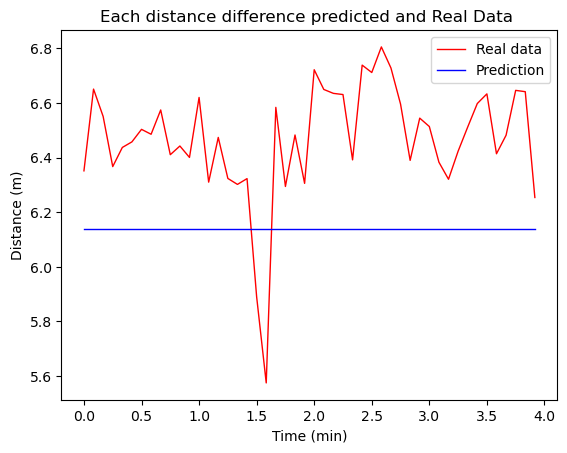

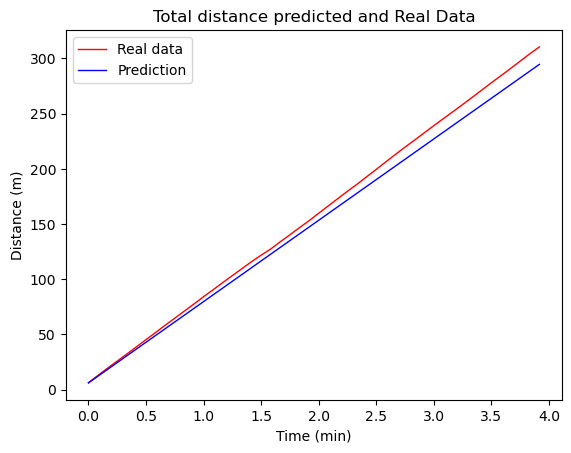

2


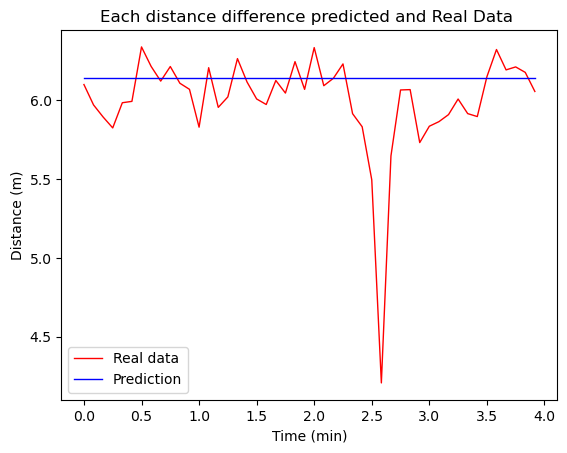

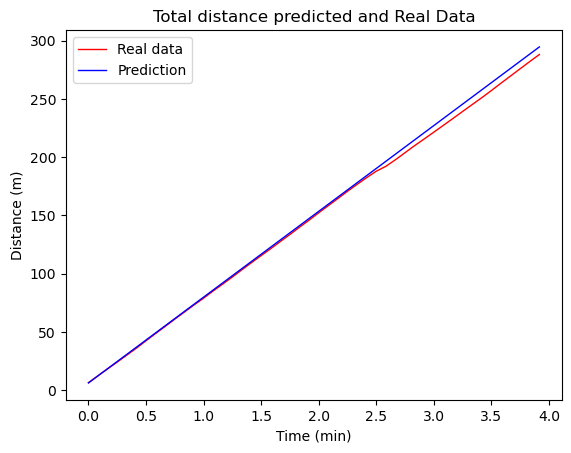

3


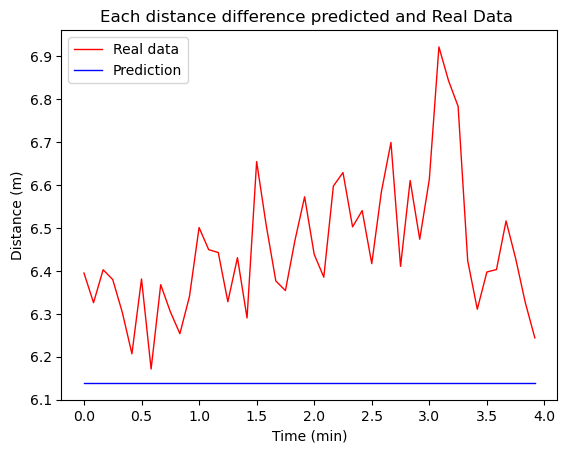

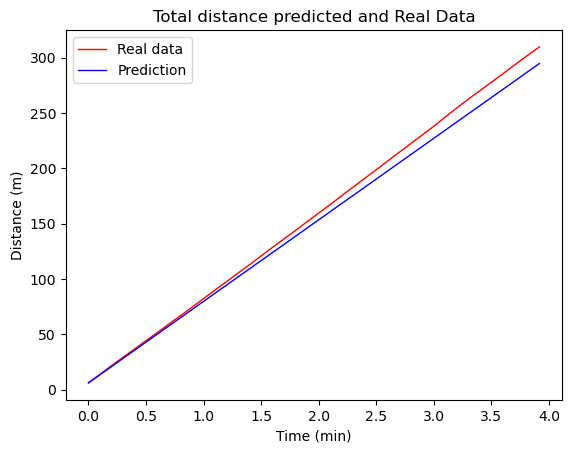

4


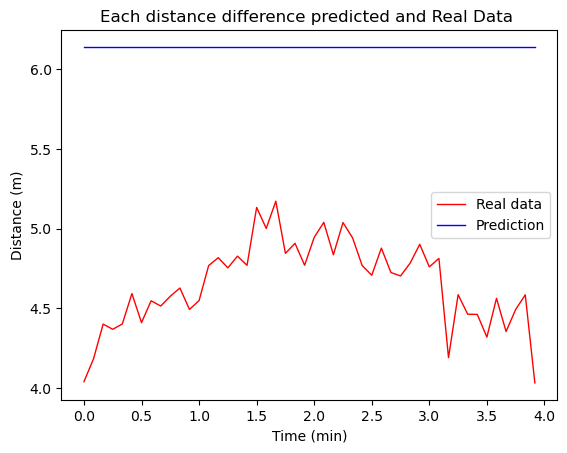

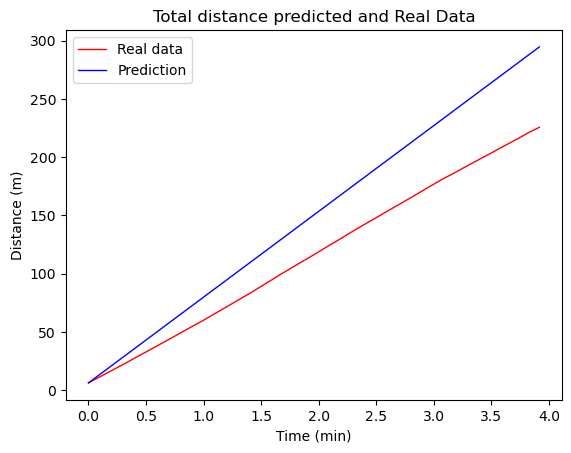

5


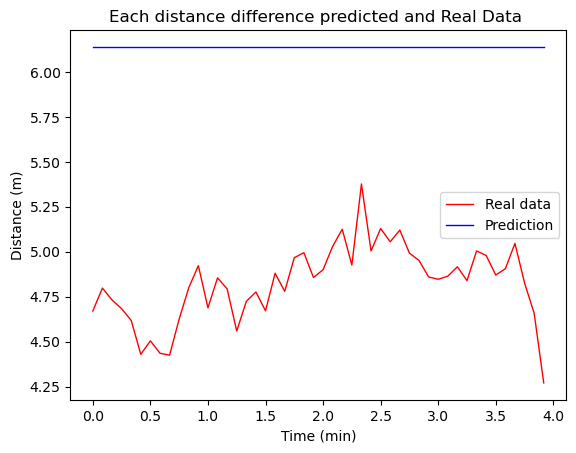

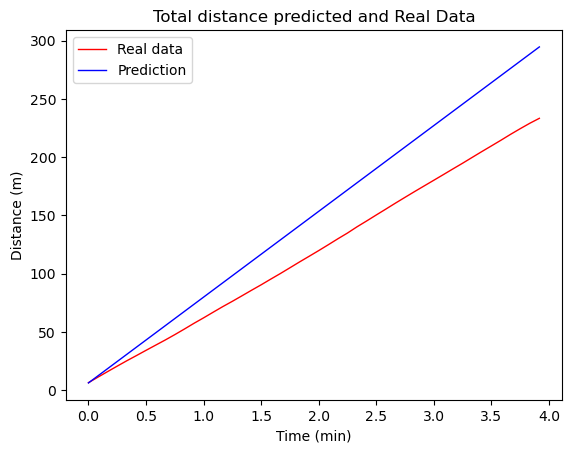

6


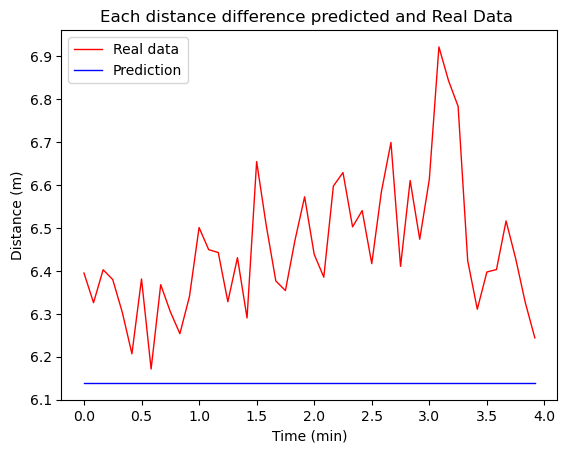

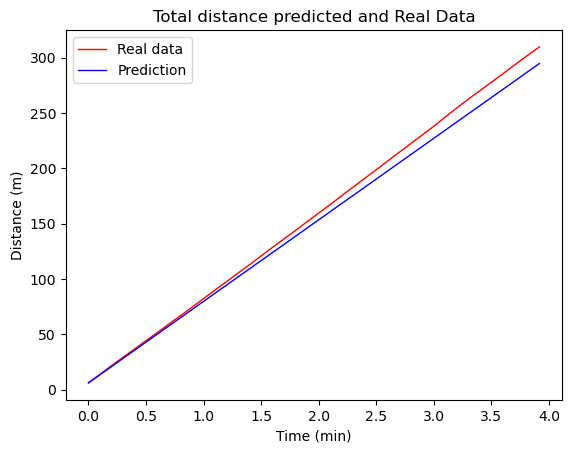

7


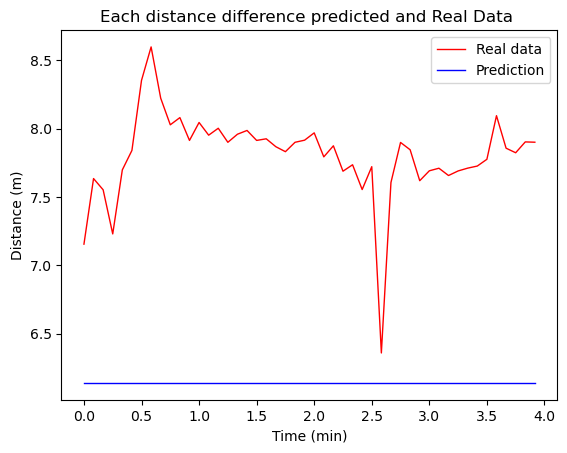

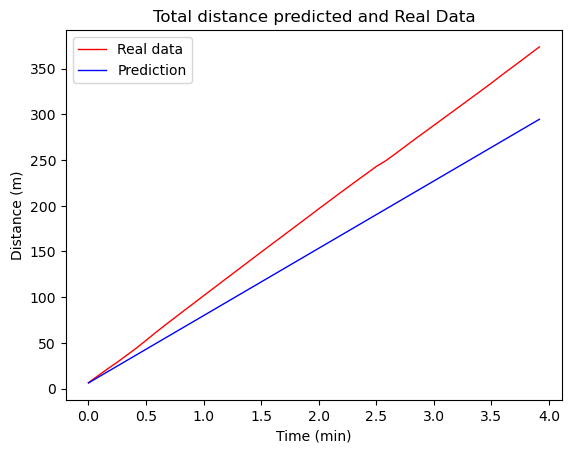

8


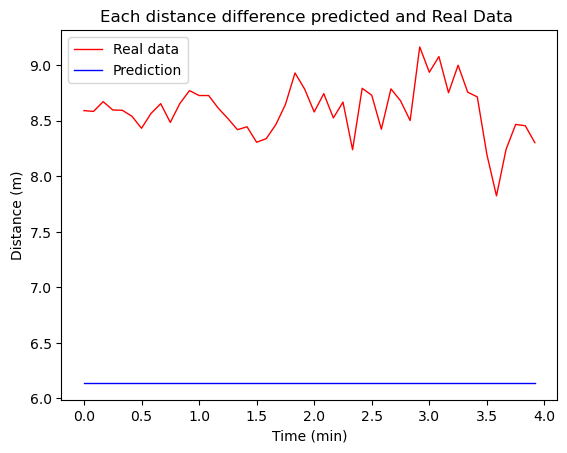

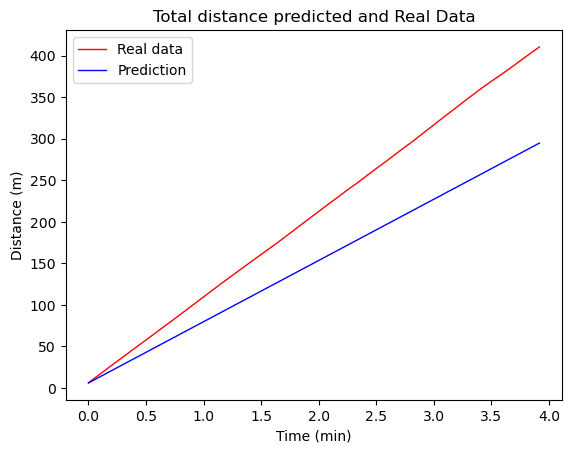

9


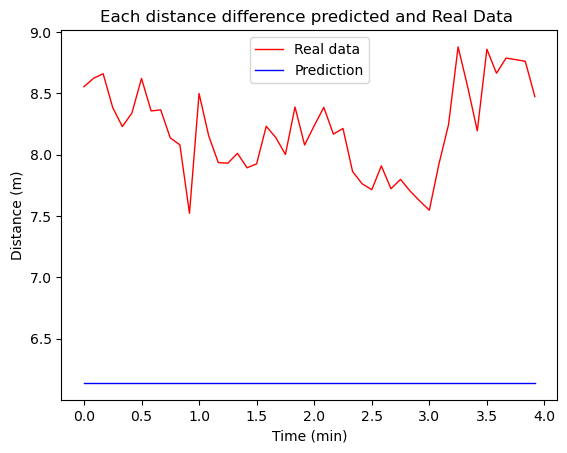

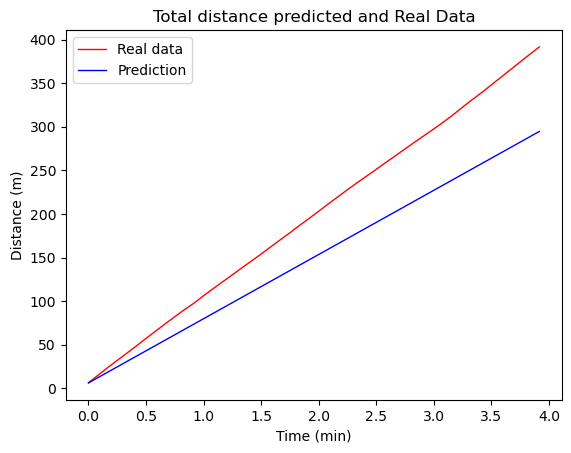

10


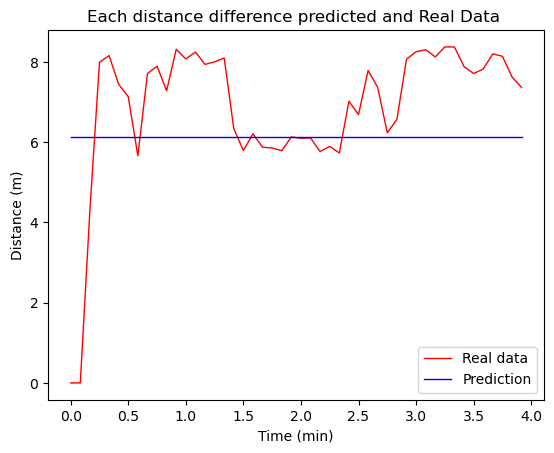

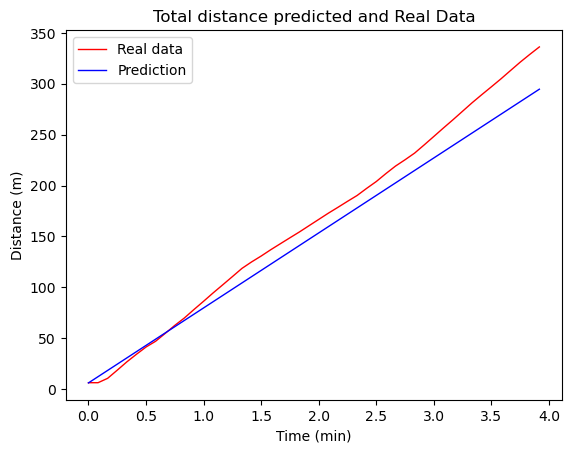

11


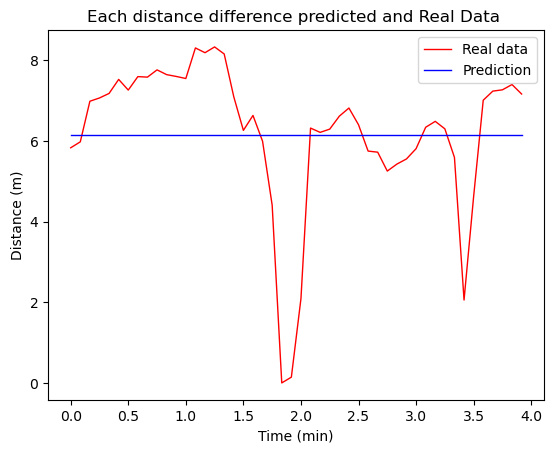

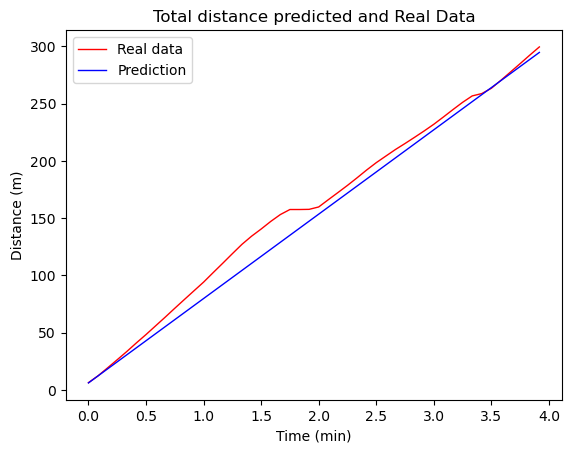

12


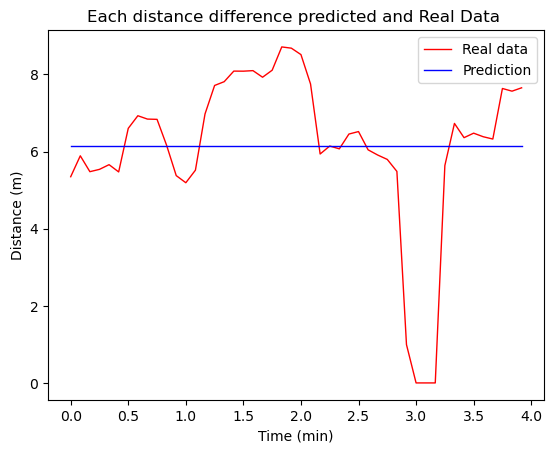

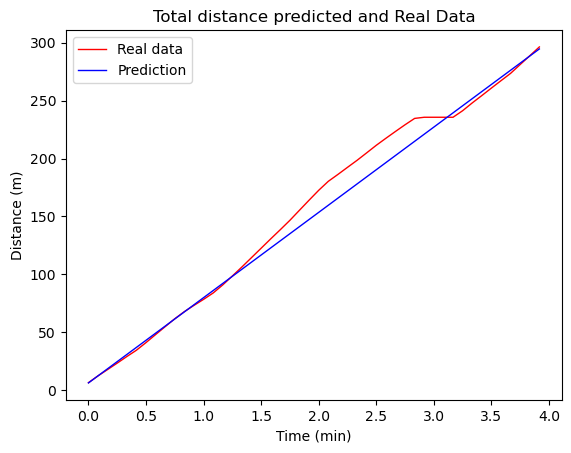

13


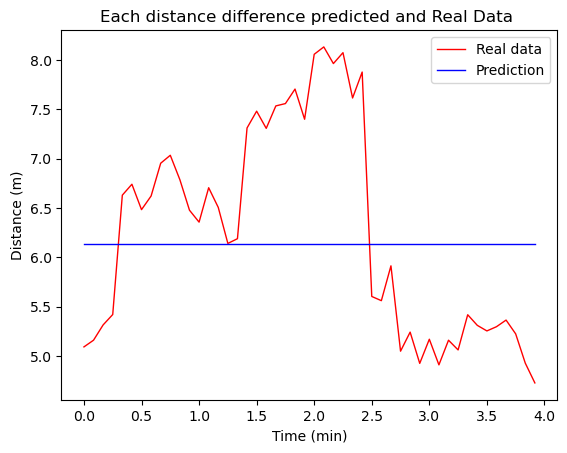

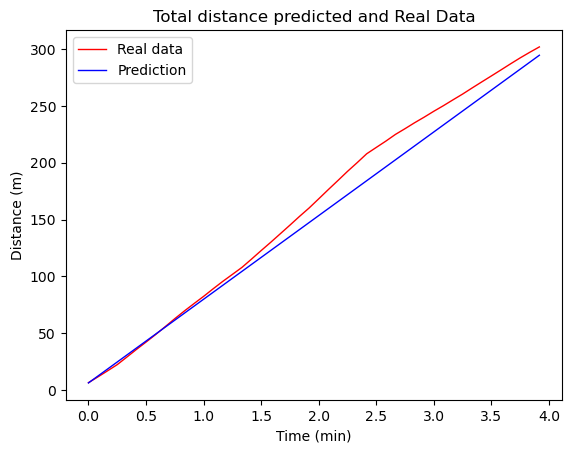

14


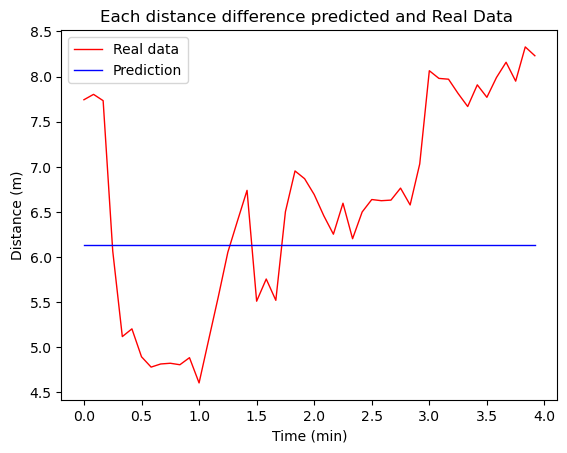

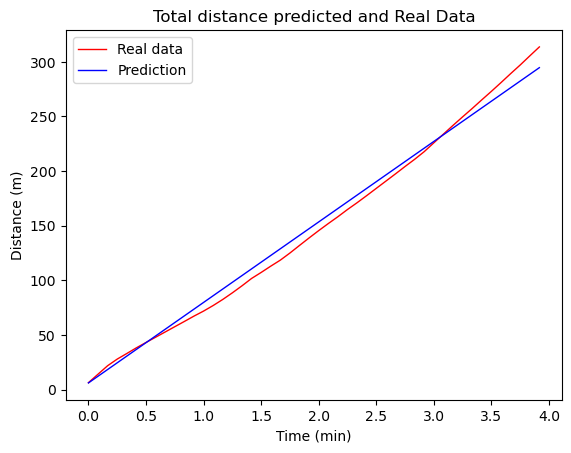

15


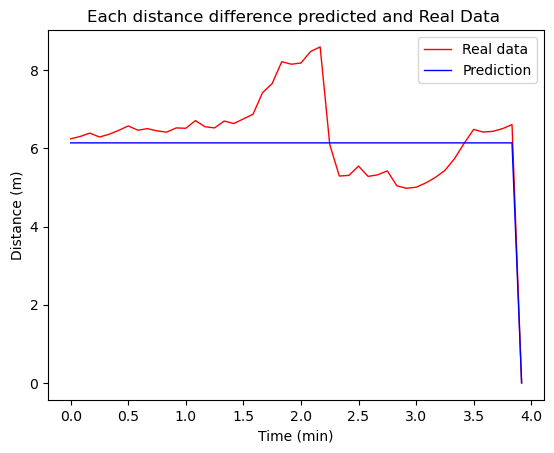

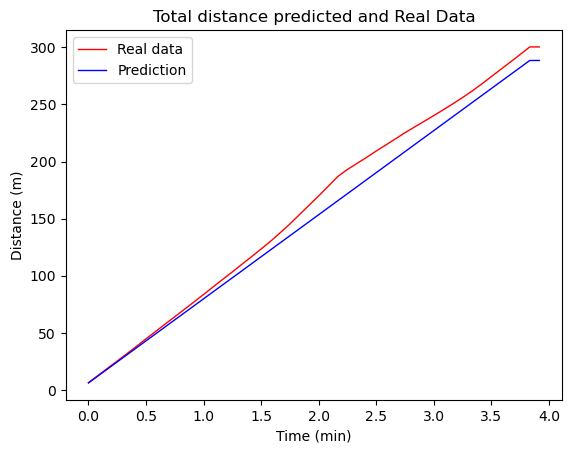

In [338]:
walks_nbr, chunks_nbr = y_p.shape
indices_x = np.arange(chunks_nbr)

for i in range(walks_nbr):

    print(i+1)
    plt.plot(indices_x*300/3600, y_r[i], 'r-', label='Real data', linewidth=1)
    plt.plot(indices_x*300/3600, y_p[i], 'b-', label='Prediction',linewidth=1)
    plt.title('Each distance difference predicted and Real Data ')
    plt.xlabel('Time (min)')
    plt.ylabel('Distance (m)')
    plt.legend()
    plt.show()
    
    sum_r = [y_r[0][0]]
    sum_p = [y_p[0][0]]
    for j in range(1, chunks_nbr):
        sum_r.append(y_r[i][j] + sum_r[-1])
        sum_p.append(y_p[i][j] + sum_p[-1])
        
    plt.plot(indices_x*300/3600, sum_r, 'r-', label='Real data', linewidth=1)
    plt.plot(indices_x*300/3600, sum_p, 'b-', label='Prediction',linewidth=1)
    plt.title('Total distance predicted and Real Data')
    plt.xlabel('Time (min)')
    plt.ylabel('Distance (m)')
    plt.legend()
    plt.show()